In [1]:
import random, numpy as np, torch
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RUN_NAME = "filtered_ae_mse_vae_bs256_ep20_sr8k_T4000" # 更新 RUN_NAME 以反映更改

In [2]:
import sys
import os, glob, random, json
import numpy as np
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # 用纯文本 tqdm，避免 ipywidgets warning


In [3]:
SAVE_DIR = "experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

cuda available: True
GPU: NVIDIA A100-SXM4-40GB


In [5]:

from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = r"/content/drive/MyDrive/hapticgen-dataset/expertvoted"

def collect_clean_wavs(root):
    wavs = []
    for meta_path in glob.glob(os.path.join(root, "**/*.am1.json"), recursive=True):
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        # 用expertvoted里面的，这里目前全是initial
        if meta.get("model") == "HapticGen-Initial" and meta.get("vote") == 1:
            wav_path = os.path.join(os.path.dirname(meta_path), meta["filename"])
            if os.path.exists(wav_path):
                wavs.append(wav_path)

    return wavs

wav_files = collect_clean_wavs(DATA_ROOT)
print("Clean wavs:", len(wav_files))

assert len(wav_files) > 0, "没有筛选到任何 HapticGenInitial + vote=1 的 wav"


assert len(wav_files) > 0, "没找到任何 wav：请检查 DATA_ROOT 是否指向正确的根目录"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Clean wavs: 585



--- The_feeling_of_drinking_cola._UMW33_1.wav
sr: 8000 len: 80000 min/max: -0.1484375 0.140625


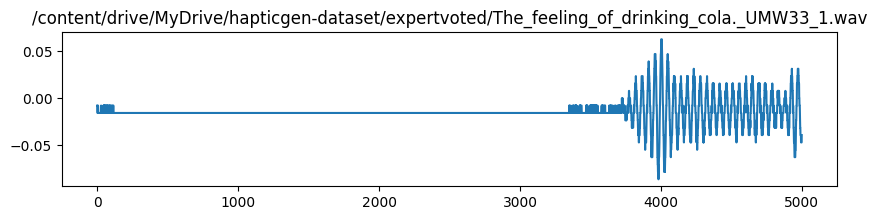


--- I_want_to_feel_like_I_m_shooting_a_machine_gun_for_SDGI6_5.wav
sr: 8000 len: 80000 min/max: -1.0 0.984375


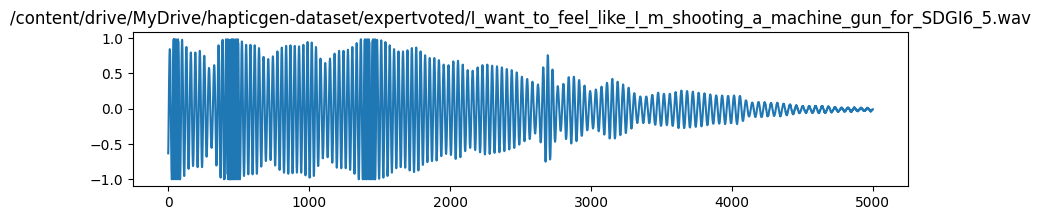


--- Hanging_on_to_a_cliff_WNNWYI_1.wav
sr: 8000 len: 80000 min/max: -0.328125 0.3125


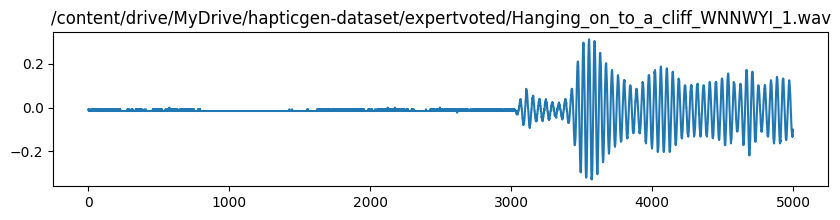

In [6]:
sample_wavs = random.sample(wav_files, 3)

for p in sample_wavs:
    y, sr = librosa.load(p, sr=None, mono=True)
    print("\n---", os.path.basename(p))
    print("sr:", sr, "len:", len(y), "min/max:", float(y.min()), float(y.max()))
    plt.figure(figsize=(10,2))
    plt.plot(y[:5000])
    plt.title(p)
    plt.show()


In [7]:
SR_EXPECT = 8000
T = 4000  # 0.5s @ 8kHz

USE_MINMAX = False  # ✅ 设为 False，禁用 min-max 归一化

def minmax_norm(seg):
    mn = seg.min()
    mx = seg.max()
    if mx - mn < 1e-8:
        return np.zeros_like(seg)
    return (seg - mn) / (mx - mn)   # [0,1]

def load_segment_energy(
    path, T=T, sr_expect=SR_EXPECT,
    tries=30, min_energy=5e-4, max_resample=5,
    fallback="best"   # "best" or "zeros"
):
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != sr_expect:
        y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)

    if len(y) < T:
        y = np.pad(y, (0, T - len(y)))

    max_start = len(y) - T  # >= 0

    best_seg_global = None
    best_energy_global = -1.0

    for _ in range(max_resample):
        best_seg = None
        best_energy = -1.0

        for _ in range(tries):
            start = np.random.randint(0, max_start + 1)
            seg = y[start:start+T]
            seg = seg - np.mean(seg)
            e = float(np.mean(seg**2))

            if e > best_energy:
                best_energy = e
                best_seg = seg

        # 记录全局最优（用于 fallback）
        if best_energy > best_energy_global:
            best_energy_global = best_energy
            best_seg_global = best_seg

        if best_energy >= min_energy:
            best_seg = best_seg_global  # 或 best_seg（两者此时一致/接近）
            break

    # ✅ 关键：不再 return None
    if best_seg_global is None:
        # 极端情况：文件读不到/空
        return np.zeros(T, dtype=np.float32)

    if best_energy_global < min_energy:
        if fallback == "zeros":
            return np.zeros(T, dtype=np.float32)
        # fallback == "best"：继续用能量最高的那段（即使低于门槛）

    # ===== 下面保持你原来的尺度归一化逻辑 =====
    SCALE = 0.25
    seg = best_seg_global / (GLOBAL_RMS + 1e-6)
    seg = seg * SCALE
    seg = np.clip(seg, -3.0, 3.0)

    if USE_MINMAX:
        seg = minmax_norm(seg)

    return seg.astype(np.float32)


In [8]:
N = len(wav_files)
perm = np.random.permutation(N)
train_idx = perm[:int(0.8 * N)]
val_idx   = perm[int(0.8 * N):]

train_files = [wav_files[i] for i in train_idx]
val_files   = [wav_files[i] for i in val_idx]

print("train:", len(train_files), "val:", len(val_files))

def estimate_global_rms(files, n=200, sr_expect=SR_EXPECT):
    picks = random.sample(files, min(n, len(files)))
    rms = []
    for p in picks:
        y, sr = librosa.load(p, sr=None, mono=True)
        if sr != sr_expect:
            y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)
        y = y - np.mean(y)
        rms.append(np.sqrt(np.mean(y**2)) + 1e-8)
    return float(np.median(rms))

GLOBAL_RMS = estimate_global_rms(train_files, n=200)
print("GLOBAL_RMS =", GLOBAL_RMS)

x = load_segment_energy(train_files[0], T=T)
print("seg std:", x.std(), "seg maxabs:", np.max(np.abs(x)))
x2 = load_segment_energy(train_files[1], T=T)
print("x2 is None?", x2 is None)
print("seg2 std:", np.std(x2), "seg2 maxabs:", np.max(np.abs(x2)))



class HapticWavDataset(Dataset):
    def __init__(self, files, T=4000):
        self.files = files
        self.T = T

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
    # 遇到 None（没找到足够能量的片段）就换文件重采样
        for _ in range(10):  # 最多尝试 10 次，避免死循环
          x = load_segment_energy(self.files[idx], T=self.T)
          if x is not None:
            return torch.from_numpy(x).unsqueeze(0)
          idx = np.random.randint(0, len(self.files))

    # 如果极端情况下 10 次都失败，返回全 0（保证类型正确）
        return torch.zeros(1, self.T, dtype=torch.float32)



batch_size = 32  # 减小batch size，让每个epoch有更多更新步骤
train_loader = DataLoader(HapticWavDataset(train_files, T=T), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(HapticWavDataset(val_files,   T=T), batch_size=batch_size, shuffle=False, drop_last=False)

# sanity check
xb = next(iter(train_loader))
print("batch shape:", xb.shape)  # (B, 1, T)


train: 468 val: 117
GLOBAL_RMS = 0.030182592570781708
seg std: 2.6841342 seg maxabs: 3.0
x2 is None? False
seg2 std: 0.10897761 seg2 maxabs: 0.7419277
batch shape: torch.Size([32, 1, 4000])


In [9]:
xb = next(iter(train_loader))  # (B,1,T)
stds = xb[:,0,:].numpy().std(axis=1)
print("silent-ish ratio:", (stds < 1e-3).mean())
print("std min/median/max:", stds.min(), np.median(stds), stds.max())


silent-ish ratio: 0.0
std min/median/max: 0.044305947 0.5042782 2.7917068


In [10]:
def GN(c):
    return nn.GroupNorm(num_groups=8, num_channels=c)

class ConvVAE(nn.Module):
    def __init__(self, T=4000, latent_dim=32, logvar_clip=(-10, 10)):
        super().__init__()
        self.T = T
        self.latent_dim = latent_dim
        self.logvar_clip = logvar_clip

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=25, stride=2, padding=12),
            GN(32), nn.LeakyReLU(0.2),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            GN(64), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, kernel_size=9, stride=2, padding=4),
            GN(128), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, kernel_size=9, stride=2, padding=4),
            GN(128), nn.LeakyReLU(0.2),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, T)
            h = self.encoder(dummy)
            self.enc_shape = h.shape[1:]
            self.enc_feat = h.numel()

        self.fc_mu     = nn.Linear(self.enc_feat, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_feat, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, self.enc_feat)

        # 使用 xavier 初始化，不要用零初始化权重
        nn.init.xavier_uniform_(self.fc_mu.weight)
        nn.init.zeros_(self.fc_mu.bias)
        nn.init.xavier_uniform_(self.fc_logvar.weight)
        nn.init.constant_(self.fc_logvar.bias, -1.0)  # 初始化为较小的方差

        # 使用 Upsample + Conv1d 替代 ConvTranspose1d
        # 避免转置卷积的棋盘格伪影(checkerboard artifacts)，输出更平滑
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Conv1d(128, 128, kernel_size=9, padding=4),
            GN(128), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Conv1d(128, 64, kernel_size=9, padding=4),
            GN(64), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Conv1d(64, 32, kernel_size=9, padding=4),
            GN(32), nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Conv1d(32, 1, kernel_size=9, padding=4),
        )

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, self.logvar_clip[0], self.logvar_clip[1])
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, logvar

    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)

        mu = self.fc_mu(h_flat)
        logvar_raw = self.fc_logvar(h_flat)
        z, logvar = self.reparameterize(mu, logvar_raw)

        h2 = self.fc_dec(z).view(x.size(0), *self.enc_shape)
        x_hat = self.decoder(h2)

        T = x.shape[-1]
        if x_hat.shape[-1] > T:
            x_hat = x_hat[..., :T]
        elif x_hat.shape[-1] < T:
            x_hat = torch.nn.functional.pad(x_hat, (0, T - x_hat.shape[-1]))

        return x_hat, mu, logvar, z


In [11]:
ckpt_path = f"{SAVE_DIR}/ckpt_{RUN_NAME}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

latent_dim = 64  # 增大潜在维度，32000:64 = 500:1 压缩比更合理
model = ConvVAE(T=T, latent_dim=latent_dim).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)  # 降低weight_decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=15)  # 增大patience，防止lr衰减太快

def multi_scale_spectral_loss(x_hat, x):
    """多尺度频谱损失：在多个频率分辨率上比较，更好地保留音频细节"""
    loss = 0.0
    x_1d = x.squeeze(1)       # (B, T)
    xh_1d = x_hat.squeeze(1)  # (B, T)
    for n_fft in [128, 256, 512, 1024]:
        # 幅度谱损失（log scale）
        x_spec = torch.stft(x_1d, n_fft, hop_length=n_fft//4, return_complex=True, window=torch.hann_window(n_fft, device=x.device))
        xh_spec = torch.stft(xh_1d, n_fft, hop_length=n_fft//4, return_complex=True, window=torch.hann_window(n_fft, device=x.device))
        # L1 幅度谱距离
        loss += torch.mean(torch.abs(torch.abs(x_spec) - torch.abs(xh_spec)))
        # Log 幅度谱距离（更关注小幅度细节）
        loss += torch.mean(torch.abs(torch.log(torch.abs(x_spec) + 1e-7) - torch.log(torch.abs(xh_spec) + 1e-7)))
    return loss / 8  # 4 scales × 2 losses

def amplitude_loss(x_hat, x):
    """振幅匹配损失：惩罚重建信号的 RMS 和峰值与原始信号的差异"""
    # 逐样本 RMS 差异
    rms_x  = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + 1e-8)
    rms_xh = torch.sqrt(torch.mean(x_hat ** 2, dim=-1, keepdim=True) + 1e-8)
    rms_diff = torch.mean((rms_x - rms_xh) ** 2)
    # 逐样本峰值差异
    peak_x  = torch.amax(torch.abs(x), dim=-1, keepdim=True)
    peak_xh = torch.amax(torch.abs(x_hat), dim=-1, keepdim=True)
    peak_diff = torch.mean((peak_x - peak_xh) ** 2)
    return rms_diff + peak_diff

def kl_divergence_free_bits(mu, logvar, free_bits=0.1):
    """
    Free-bits KL: 每个维度至少允许 free_bits nats 的信息
    防止后验坍塌
    """
    # 每个维度的 KL
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # (B, latent_dim)
    # 对每个维度应用 free_bits 门槛
    kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)
    # 对维度求和，对 batch 求平均
    return kl_per_dim.sum(dim=1).mean()


def cyclical_beta_schedule(epoch, total_epochs, n_cycles=4, ratio=0.5, beta_max=0.0001):
    """
    Cyclical annealing: beta 周期性从 0 上升到 beta_max
    - n_cycles: 周期数
    - ratio: 每个周期中上升阶段的比例
    """
    cycle_length = total_epochs / n_cycles
    cycle_pos = epoch % cycle_length

    if cycle_pos / cycle_length < ratio:
        # 上升阶段
        return beta_max * (cycle_pos / (cycle_length * ratio))
    else:
        # 保持阶段
        return beta_max


total_epochs = 100  # 增加训练轮数
print_every = 10  # 每10个epoch打印一次
patience = 15  # 增大 patience，因为 cyclical annealing 会导致 loss 波动
min_delta = 1e-4

train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
wait = 0


device: cuda
ConvVAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): GroupNorm(8, 128, eps=1e-05, affine=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (10): GroupNorm(8, 128, eps=1e-05, affine=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=32000, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,), outp

In [12]:
print("train batches:", len(train_loader), "val batches:", len(val_loader))
print("train size:", len(train_loader.dataset), "val size:", len(val_loader.dataset))
print("one val batch shape:", next(iter(val_loader)).shape)



train batches: 14 val batches: 4
train size: 468 val size: 117
one val batch shape: torch.Size([32, 1, 4000])


In [13]:

def run_epoch(loader, train=True, epoch=1):
    model.train(train)
    total_loss = 0.0
    count = 0

    mode = "train" if train else "val"
    if len(loader) == 0:
        raise ValueError("val_loader is empty (len==0). Check your val split / DataLoader.")

    pbar = tqdm(loader, leave=False, desc=f"{mode} epoch {epoch}")

    for batch_idx, x in enumerate(pbar):
        x = x.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        x_hat_raw, mu, logvar, z = model(x)
        if batch_idx == 0:
          print(f"RAW x_hat stats [{mode.upper()}]:",
          "min =", x_hat_raw.detach().min().item(),
          "max =", x_hat_raw.detach().max().item(),
          "mean =", x_hat_raw.detach().mean().item(),
          "std =", x_hat_raw.detach().std().item())

        x_hat = torch.clamp(x_hat_raw, -3.0, 3.0)  # 简单 clamp 到输入范围

        mse = torch.nn.functional.mse_loss(x_hat, x)
        l1  = torch.nn.functional.l1_loss(x_hat, x)
        spec = multi_scale_spectral_loss(x_hat, x)
        amp  = amplitude_loss(x_hat, x)
        recon = mse + 0.2 * l1 + 0.15 * spec + 0.5 * amp

        # 使用 free-bits KL 防止后验坍塌
        kl = kl_divergence_free_bits(mu, logvar, free_bits=0.1)

        # 使用 cyclical annealing
        beta = cyclical_beta_schedule(epoch, total_epochs, n_cycles=4, ratio=0.5, beta_max=0.0001)

        # VAE 损失 = 重建损失 + beta * KL散度
        loss = recon + beta * kl


        # ✅ 只在非有限时跳过
        if not torch.isfinite(loss):
            print("⚠️ non-finite loss, skip batch",
                  "recon=", recon.detach().item(),
                  "kl=", kl.detach().item(),
                  "beta=", beta,
                  "logvar min/max=", logvar.detach().min().item(), logvar.detach().max().item())
            continue

        # ✅ debug：只打印每个 epoch 的第一个 batch
        if batch_idx == 0:
            print(f"DEBUG {mode.upper()}:",
                  "x min/max", x.detach().min().item(), x.detach().max().item(),
                  "| x_hat min/max", x_hat.detach().min().item(), x_hat.detach().max().item(),
                  "| recon", recon.detach().item(),
                  "| kl", kl.detach().item(),
                  "| beta", beta)
            print("mu abs mean:", mu.detach().abs().mean().item(),
                  "logvar min/max:", logvar.detach().min().item(), logvar.detach().max().item())

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = x.shape[0]
        total_loss += loss.detach().item() * bs
        count += bs

        pbar.set_postfix(loss=f"{(total_loss/max(count,1)):.4f}",
                         recon=f"{recon.detach().item():.4f}",
                         kl=f"{kl.detach().item():.4f}",
                         beta=f"{beta:.1e}")

    return total_loss / max(count, 1)


# ========= training loop + early stopping =========
early_stop_start = 10   # ✅ 前10个epoch不early stop（建议）
best_val = float("inf") # 确保初始化正确
wait = 0

for epoch in range(1, total_epochs + 1):
    tr = run_epoch(train_loader, train=True,  epoch=epoch)
    va = run_epoch(val_loader,   train=False, epoch=epoch)

    train_losses.append(tr)
    val_losses.append(va)

    # ✅ scheduler 只在 va 有效时 step
    if np.isfinite(va):
        scheduler.step(va)
    lr = optimizer.param_groups[0]["lr"]

    if epoch % print_every == 0 or epoch == 1:
        overall = 100.0 * epoch / total_epochs
        print(f"[Epoch {epoch:03d}/{total_epochs} | overall {overall:5.1f}%] "
              f"lr={lr:.2e} | train={tr:.6f} | val={va:.6f}")

    # ✅ early stopping（warmup 后才启用）
    if epoch >= early_stop_start:
        if (not np.isfinite(va)):
            wait += 1
        elif va < best_val - min_delta:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
            torch.save(best_state, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best val = {best_val:.6f}")
                break

print("✅ Best val:", best_val)
print("✅ Saved best model weights to:", ckpt_path)

# ========= load best =========
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()


train epoch 1:   0%|          | 0/14 [00:00<?, ?it/s]

RAW x_hat stats [TRAIN]: min = -5.385101318359375 max = 8.974899291992188 mean = 1.187698245048523 std = 1.7163505554199219
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 6.527052879333496 | kl 59.83344268798828 | beta 8.000000000000001e-06
mu abs mean: 0.8937615156173706 logvar min/max: -4.193312644958496 1.9093163013458252


val epoch 1:  50%|█████     | 2/4 [00:00<00:00,  7.11it/s, beta=8.0e-06, kl=3060.1956, loss=1.5321, recon=1.4165]

RAW x_hat stats [VAL]: min = -1.042328119277954 max = 1.3261768817901611 mean = 0.10349219292402267 std = 0.2058621048927307
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.042328119277954 1.3261768817901611 | recon 1.599106788635254 | kl 3028.084716796875 | beta 8.000000000000001e-06
mu abs mean: 7.9796881675720215 logvar min/max: -10.0 -2.002983331680298


[Epoch 001/100 | overall   1.0%] lr=2.00e-04 | train=3.194744 | val=1.875420


train epoch 2:   7%|▋         | 1/14 [00:00<00:01,  6.77it/s, beta=1.6e-05, kl=3098.6035, loss=1.9318, recon=1.8823]

RAW x_hat stats [TRAIN]: min = -0.9966073632240295 max = 1.3208730220794678 mean = 0.10370530933141708 std = 0.20583395659923553
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.9966073632240295 1.3208730220794678 | recon 1.8822693824768066 | kl 3098.603515625 | beta 1.6000000000000003e-05
mu abs mean: 8.081804275512695 logvar min/max: -10.0 -2.150297164916992


val epoch 2:  50%|█████     | 2/4 [00:00<00:00,  7.41it/s, beta=1.6e-05, kl=1073.3501, loss=1.5547, recon=1.3736]

RAW x_hat stats [VAL]: min = -0.7150978446006775 max = 0.905772864818573 mean = 0.052752818912267685 std = 0.11762677878141403
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7150978446006775 0.905772864818573 | recon 1.7018136978149414 | kl 1048.5390625 | beta 1.6000000000000003e-05
mu abs mean: 4.367424011230469 logvar min/max: -10.0 -1.4182451963424683


train epoch 3:  14%|█▍        | 2/14 [00:00<00:01,  7.16it/s, beta=2.4e-05, kl=1131.4609, loss=1.9090, recon=1.8242]

RAW x_hat stats [TRAIN]: min = -0.7627224326133728 max = 0.8927316069602966 mean = 0.05272199586033821 std = 0.11615771800279617
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7627224326133728 0.8927316069602966 | recon 1.9399129152297974 | kl 1114.588623046875 | beta 2.4e-05
mu abs mean: 4.520870208740234 logvar min/max: -10.0 -2.5713322162628174


val epoch 3:  50%|█████     | 2/4 [00:00<00:00,  7.00it/s, beta=2.4e-05, kl=642.9055, loss=1.4460, recon=1.1686]

RAW x_hat stats [VAL]: min = -0.8648635745048523 max = 0.908317506313324 mean = -0.015508810989558697 std = 0.10024584084749222
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.8648635745048523 0.908317506313324 | recon 1.6930419206619263 | kl 624.1812744140625 | beta 2.4e-05
mu abs mean: 3.2627182006835938 logvar min/max: -10.0 -1.9316165447235107


train epoch 4:  14%|█▍        | 2/14 [00:00<00:01,  7.05it/s, beta=3.2e-05, kl=605.0225, loss=1.7862, recon=1.5031]

RAW x_hat stats [TRAIN]: min = -0.815142035484314 max = 0.8781542181968689 mean = -0.015342156402766705 std = 0.10016053915023804
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.815142035484314 0.8781542181968689 | recon 2.029968500137329 | kl 625.0816040039062 | beta 3.2000000000000005e-05
mu abs mean: 3.262357234954834 logvar min/max: -10.0 -1.8179765939712524


val epoch 4:  50%|█████     | 2/4 [00:00<00:00,  7.48it/s, beta=3.2e-05, kl=457.8653, loss=1.5949, recon=1.3801]

RAW x_hat stats [VAL]: min = -0.6104461550712585 max = 0.8317478895187378 mean = 0.00680483179166913 std = 0.0966477245092392
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.6104461550712585 0.8317478895187378 | recon 1.7808423042297363 | kl 445.341796875 | beta 3.2000000000000005e-05
mu abs mean: 2.64280366897583 logvar min/max: -10.0 -0.05913138389587402


train epoch 5:  14%|█▍        | 2/14 [00:00<00:01,  7.21it/s, beta=4.0e-05, kl=466.2231, loss=1.7346, recon=1.2638]

RAW x_hat stats [TRAIN]: min = -0.6081517338752747 max = 0.8090599179267883 mean = 0.006918034050613642 std = 0.0973438248038292
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.6081517338752747 0.8090599179267883 | recon 2.168766498565674 | kl 451.2802429199219 | beta 4e-05
mu abs mean: 2.657883644104004 logvar min/max: -10.0 -0.17388629913330078


val epoch 5:  50%|█████     | 2/4 [00:00<00:00,  6.73it/s, beta=4.0e-05, kl=425.7034, loss=1.6143, recon=1.4707]

RAW x_hat stats [VAL]: min = -0.9640019536018372 max = 1.0061933994293213 mean = 0.009092812426388264 std = 0.10075592249631882
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.9640019536018372 1.0061933994293213 | recon 1.7242003679275513 | kl 414.4708557128906 | beta 4e-05
mu abs mean: 2.6019396781921387 logvar min/max: -10.0 2.249738931655884


train epoch 6:  14%|█▍        | 2/14 [00:00<00:01,  6.59it/s, beta=4.8e-05, kl=393.8123, loss=2.6783, recon=2.4262]

RAW x_hat stats [TRAIN]: min = -1.0156874656677246 max = 0.8945204019546509 mean = 0.009274382144212723 std = 0.10635453462600708
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.0156874656677246 0.8945204019546509 | recon 2.8925905227661133 | kl 393.0540771484375 | beta 4.8e-05
mu abs mean: 2.5225305557250977 logvar min/max: -10.0 1.9140658378601074


val epoch 6:  50%|█████     | 2/4 [00:00<00:00,  7.75it/s, beta=4.8e-05, kl=766.8411, loss=1.6320, recon=1.4427]

RAW x_hat stats [VAL]: min = -0.7397029399871826 max = 0.6673545241355896 mean = -0.04054790735244751 std = 0.08967330306768417
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7397029399871826 0.6673545241355896 | recon 1.7492785453796387 | kl 735.3292236328125 | beta 4.8e-05
mu abs mean: 3.4670846462249756 logvar min/max: -10.0 -0.6286865472793579


train epoch 7:  14%|█▍        | 2/14 [00:00<00:01,  6.45it/s, beta=5.6e-05, kl=684.5119, loss=1.9745, recon=1.2473]

RAW x_hat stats [TRAIN]: min = -0.7120280265808105 max = 0.6445359587669373 mean = -0.0405103825032711 std = 0.0906316339969635
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7120280265808105 0.6445359587669373 | recon 2.623746633529663 | kl 707.2076416015625 | beta 5.6000000000000006e-05
mu abs mean: 3.3770031929016113 logvar min/max: -10.0 -0.47690433263778687


val epoch 7:  50%|█████     | 2/4 [00:00<00:00,  7.25it/s, beta=5.6e-05, kl=367.3296, loss=1.5234, recon=1.3244]

RAW x_hat stats [VAL]: min = -0.7902971506118774 max = 0.8067398071289062 mean = -0.011731598526239395 std = 0.10303672403097153
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7902971506118774 0.8067398071289062 | recon 1.682131290435791 | kl 350.92828369140625 | beta 5.6000000000000006e-05
mu abs mean: 2.072794198989868 logvar min/max: -10.0 0.4631959795951843


train epoch 8:  14%|█▍        | 2/14 [00:00<00:01,  6.99it/s, beta=6.4e-05, kl=369.2393, loss=1.6592, recon=1.1894]

RAW x_hat stats [TRAIN]: min = -0.7315776348114014 max = 0.6932363510131836 mean = -0.01177196204662323 std = 0.10186154395341873
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7315776348114014 0.6932363510131836 | recon 2.0827980041503906 | kl 354.6174621582031 | beta 6.400000000000001e-05
mu abs mean: 2.0839147567749023 logvar min/max: -10.0 1.0210018157958984


val epoch 8:  50%|█████     | 2/4 [00:00<00:00,  7.43it/s, beta=6.4e-05, kl=258.9469, loss=1.4122, recon=1.2590]

RAW x_hat stats [VAL]: min = -0.7089023590087891 max = 0.807155966758728 mean = 0.002401522360742092 std = 0.0884457677602768
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7089023590087891 0.807155966758728 | recon 1.5328993797302246 | kl 250.12234497070312 | beta 6.400000000000001e-05
mu abs mean: 1.7154664993286133 logvar min/max: -10.0 1.313765048980713


train epoch 9:  14%|█▍        | 2/14 [00:00<00:01,  7.02it/s, beta=7.2e-05, kl=246.3899, loss=1.8699, recon=1.5948]

RAW x_hat stats [TRAIN]: min = -0.5831555724143982 max = 0.6516926884651184 mean = 0.0021809169556945562 std = 0.08730345219373703
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.5831555724143982 0.6516926884651184 | recon 2.109004020690918 | kl 252.13943481445312 | beta 7.2e-05
mu abs mean: 1.719624400138855 logvar min/max: -10.0 0.19604963064193726


val epoch 9:  50%|█████     | 2/4 [00:00<00:00,  7.33it/s, beta=7.2e-05, kl=204.7202, loss=1.5521, recon=1.3357]

RAW x_hat stats [VAL]: min = -0.7343809604644775 max = 0.7806606888771057 mean = 0.009480869397521019 std = 0.08486270159482956
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7343809604644775 0.7806606888771057 | recon 1.7396875619888306 | kl 195.45968627929688 | beta 7.2e-05
mu abs mean: 1.3569693565368652 logvar min/max: -10.0 1.005617380142212


train epoch 10:  14%|█▍        | 2/14 [00:00<00:01,  6.48it/s, beta=8.0e-05, kl=193.2193, loss=1.9078, recon=2.0497]

RAW x_hat stats [TRAIN]: min = -0.6863656044006348 max = 0.6874270439147949 mean = 0.009420800022780895 std = 0.08248330652713776
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.6863656044006348 0.6874270439147949 | recon 1.7346341609954834 | kl 196.58226013183594 | beta 8e-05
mu abs mean: 1.3606230020523071 logvar min/max: -10.0 0.5207310318946838


val epoch 10:  50%|█████     | 2/4 [00:00<00:00,  7.15it/s, beta=8.0e-05, kl=186.8140, loss=1.6312, recon=1.5010]

RAW x_hat stats [VAL]: min = -0.7097956538200378 max = 0.5949456095695496 mean = -0.008597076870501041 std = 0.08033683151006699
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7097956538200378 0.5949456095695496 | recon 1.7320497035980225 | kl 180.68267822265625 | beta 8e-05
mu abs mean: 1.263169527053833 logvar min/max: -10.0 0.6680641770362854


[Epoch 010/100 | overall  10.0%] lr=2.00e-04 | train=1.970539 | val=1.811822


train epoch 11:   0%|          | 0/14 [00:00<?, ?it/s]

RAW x_hat stats [TRAIN]: min = -0.5690134763717651 max = 0.4871939420700073 mean = -0.008876574225723743 std = 0.07435548305511475
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.5690134763717651 0.4871939420700073 | recon 1.583682894706726 | kl 185.4175262451172 | beta 8.800000000000001e-05
mu abs mean: 1.2869994640350342 logvar min/max: -10.0 0.02930319309234619


val epoch 11:  50%|█████     | 2/4 [00:00<00:00,  7.65it/s, beta=8.8e-05, kl=178.5957, loss=1.6326, recon=1.4598]

RAW x_hat stats [VAL]: min = -0.7762495279312134 max = 0.7825080752372742 mean = -0.0036452915519475937 std = 0.09537585824728012
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7762495279312134 0.7825080752372742 | recon 1.7739731073379517 | kl 178.45458984375 | beta 8.800000000000001e-05
mu abs mean: 1.3470262289047241 logvar min/max: -10.0 2.807443618774414


train epoch 12:  14%|█▍        | 2/14 [00:00<00:01,  6.96it/s, beta=9.6e-05, kl=190.1863, loss=1.9813, recon=1.5444]

RAW x_hat stats [TRAIN]: min = -0.673259973526001 max = 0.6977836489677429 mean = -0.0034505221992731094 std = 0.10002809017896652
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.673259973526001 0.6977836489677429 | recon 2.383129596710205 | kl 174.8389892578125 | beta 9.6e-05
mu abs mean: 1.3217699527740479 logvar min/max: -10.0 2.9646713733673096


val epoch 12:  50%|█████     | 2/4 [00:00<00:00,  7.41it/s, beta=9.6e-05, kl=185.1945, loss=1.5475, recon=1.3104]

RAW x_hat stats [VAL]: min = -0.7254348993301392 max = 0.83648681640625 mean = 0.01592301018536091 std = 0.09914546459913254
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7254348993301392 0.83648681640625 | recon 1.7495181560516357 | kl 181.3246612548828 | beta 9.6e-05
mu abs mean: 1.2592203617095947 logvar min/max: -10.0 2.491302967071533


train epoch 13:   7%|▋         | 1/14 [00:00<00:01,  7.54it/s, beta=1.0e-04, kl=186.1622, loss=1.4201, recon=1.4015]

RAW x_hat stats [TRAIN]: min = -0.49642789363861084 max = 0.7214082479476929 mean = 0.014681671746075153 std = 0.08927935361862183
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.49642789363861084 0.7214082479476929 | recon 1.4015159606933594 | kl 186.16221618652344 | beta 0.0001
mu abs mean: 1.2923208475112915 logvar min/max: -10.0 0.3108617663383484


val epoch 13:  50%|█████     | 2/4 [00:00<00:00,  7.89it/s, beta=1.0e-04, kl=187.8176, loss=1.5057, recon=1.2709]

RAW x_hat stats [VAL]: min = -0.7248983383178711 max = 0.6626971960067749 mean = -0.01577865518629551 std = 0.10306140035390854
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7248983383178711 0.6626971960067749 | recon 1.7027628421783447 | kl 189.8489990234375 | beta 0.0001
mu abs mean: 1.3482251167297363 logvar min/max: -10.0 2.683720827102661


train epoch 14:  14%|█▍        | 2/14 [00:00<00:01,  6.43it/s, beta=1.0e-04, kl=187.9905, loss=2.1561, recon=2.0505]

RAW x_hat stats [TRAIN]: min = -0.7193319797515869 max = 0.716181755065918 mean = -0.015622383914887905 std = 0.10905982553958893
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7193319797515869 0.716181755065918 | recon 2.224377393722534 | kl 185.47964477539062 | beta 0.0001
mu abs mean: 1.293520212173462 logvar min/max: -10.0 3.4042463302612305


val epoch 14:  50%|█████     | 2/4 [00:00<00:00,  7.33it/s, beta=1.0e-04, kl=283.4718, loss=1.4935, recon=1.2784]

RAW x_hat stats [VAL]: min = -1.0123274326324463 max = 0.9360498189926147 mean = 0.02056499570608139 std = 0.13344338536262512
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.0123274326324463 0.9360498189926147 | recon 1.6504011154174805 | kl 297.8633728027344 | beta 0.0001
mu abs mean: 1.9470772743225098 logvar min/max: -10.0 2.3716249465942383


train epoch 15:  14%|█▍        | 2/14 [00:00<00:01,  6.28it/s, beta=1.0e-04, kl=307.6812, loss=2.1328, recon=2.7671]

RAW x_hat stats [TRAIN]: min = -0.9803128242492676 max = 0.9605234861373901 mean = 0.019425837323069572 std = 0.12622442841529846
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.9803128242492676 0.9605234861373901 | recon 1.4377727508544922 | kl 299.39349365234375 | beta 0.0001
mu abs mean: 1.9637267589569092 logvar min/max: -10.0 0.8137425780296326


val epoch 15:  50%|█████     | 2/4 [00:00<00:00,  7.29it/s, beta=1.0e-04, kl=259.8784, loss=1.3659, recon=1.2672]

RAW x_hat stats [VAL]: min = -1.8914092779159546 max = 2.2794456481933594 mean = 0.013234219513833523 std = 0.33976826071739197
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.8914092779159546 2.2794456481933594 | recon 1.4121818542480469 | kl 264.7123107910156 | beta 0.0001
mu abs mean: 1.6643608808517456 logvar min/max: -10.0 1.2934576272964478


train epoch 16:  14%|█▍        | 2/14 [00:00<00:01,  6.55it/s, beta=1.0e-04, kl=268.1610, loss=1.4244, recon=1.4131]

RAW x_hat stats [TRAIN]: min = -1.8962271213531494 max = 2.1027169227600098 mean = 0.012184597551822662 std = 0.3127797544002533
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.8962271213531494 2.1027169227600098 | recon 1.3820244073867798 | kl 268.3123779296875 | beta 0.0001
mu abs mean: 1.683509111404419 logvar min/max: -10.0 1.8993570804595947


val epoch 16:  50%|█████     | 2/4 [00:00<00:00,  7.27it/s, beta=1.0e-04, kl=426.8914, loss=1.1402, recon=0.9014]

RAW x_hat stats [VAL]: min = -3.011539936065674 max = 3.3663554191589355 mean = 0.001889972947537899 std = 0.5487344264984131
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.29295015335083 | kl 432.1671142578125 | beta 0.0001
mu abs mean: 2.4670162200927734 logvar min/max: -10.0 -0.8922195434570312


train epoch 17:  14%|█▍        | 2/14 [00:00<00:01,  6.22it/s, beta=1.0e-04, kl=774.6086, loss=1.6039, recon=1.3258]

RAW x_hat stats [TRAIN]: min = -3.411531925201416 max = 3.6588237285614014 mean = 0.006250051781535149 std = 0.6577839255332947
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.7617754936218262 | kl 428.1607666015625 | beta 0.0001
mu abs mean: 2.3779101371765137 logvar min/max: -10.0 0.7052878737449646


val epoch 17:  50%|█████     | 2/4 [00:00<00:00,  7.57it/s, beta=1.0e-04, kl=386.3318, loss=1.0427, recon=0.8132]

RAW x_hat stats [VAL]: min = -4.134582996368408 max = 4.759900093078613 mean = 0.006889812182635069 std = 0.6229842305183411
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.1961342096328735 | kl 374.3473205566406 | beta 0.0001
mu abs mean: 2.238492250442505 logvar min/max: -10.0 -0.5736181735992432


train epoch 18:  14%|█▍        | 2/14 [00:00<00:01,  6.25it/s, beta=1.0e-04, kl=411.7146, loss=1.8314, recon=1.7135]

RAW x_hat stats [TRAIN]: min = -4.159739017486572 max = 4.41880464553833 mean = 0.01035453099757433 std = 0.750943124294281
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.8688255548477173 | kl 392.18988037109375 | beta 0.0001
mu abs mean: 2.2671380043029785 logvar min/max: -10.0 1.479743480682373


val epoch 18:  50%|█████     | 2/4 [00:00<00:00,  7.50it/s, beta=1.0e-04, kl=420.1001, loss=1.0316, recon=0.9269]

RAW x_hat stats [VAL]: min = -4.241177082061768 max = 4.278406620025635 mean = 0.006013897247612476 std = 0.7854317426681519
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0534858703613281 | kl 407.1225891113281 | beta 0.0001
mu abs mean: 2.3287246227264404 logvar min/max: -10.0 1.6106007099151611


train epoch 19:  14%|█▍        | 2/14 [00:00<00:01,  6.35it/s, beta=1.0e-04, kl=416.4587, loss=1.0889, recon=1.0636]

RAW x_hat stats [TRAIN]: min = -4.366604804992676 max = 4.548905372619629 mean = 0.007581918500363827 std = 0.8414758443832397
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0292456150054932 | kl 432.8829345703125 | beta 0.0001
mu abs mean: 2.446619987487793 logvar min/max: -10.0 0.4430910348892212


val epoch 19:  50%|█████     | 2/4 [00:00<00:00,  7.22it/s, beta=1.0e-04, kl=379.9189, loss=0.7808, recon=0.6574]

RAW x_hat stats [VAL]: min = -4.828194618225098 max = 4.8059515953063965 mean = -0.02234692871570587 std = 0.7637237906455994
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8281566500663757 | kl 380.06976318359375 | beta 0.0001
mu abs mean: 2.1751866340637207 logvar min/max: -10.0 -0.7553513050079346


train epoch 20:  14%|█▍        | 2/14 [00:00<00:01,  7.48it/s, beta=1.0e-04, kl=387.4107, loss=1.6011, recon=1.3072]

RAW x_hat stats [TRAIN]: min = -4.392719745635986 max = 4.712224006652832 mean = -0.021705910563468933 std = 0.8848405480384827
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.8172956705093384 | kl 388.8414306640625 | beta 0.0001
mu abs mean: 2.1893229484558105 logvar min/max: -10.0 1.4714064598083496


val epoch 20:  50%|█████     | 2/4 [00:00<00:00,  7.47it/s, beta=1.0e-04, kl=378.7988, loss=0.9273, recon=0.7539]

RAW x_hat stats [VAL]: min = -4.748065948486328 max = 4.706256866455078 mean = -0.01678558439016342 std = 0.8247708678245544
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0254498720169067 | kl 374.53277587890625 | beta 0.0001
mu abs mean: 2.148545980453491 logvar min/max: -10.0 -1.1485106945037842


[Epoch 020/100 | overall  20.0%] lr=2.00e-04 | train=1.181847 | val=1.043752


train epoch 21:   7%|▋         | 1/14 [00:00<00:01,  7.36it/s, beta=1.0e-04, kl=404.5894, loss=1.8050, recon=1.7645]

RAW x_hat stats [TRAIN]: min = -4.853841304779053 max = 5.358651638031006 mean = -0.01776093617081642 std = 0.8801772594451904
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.7645111083984375 | kl 404.58935546875 | beta 0.0001
mu abs mean: 2.247993230819702 logvar min/max: -10.0 -1.863328218460083


val epoch 21:  50%|█████     | 2/4 [00:00<00:00,  6.90it/s, beta=1.0e-04, kl=384.9692, loss=0.8493, recon=0.6716]

RAW x_hat stats [VAL]: min = -5.426206111907959 max = 5.226561069488525 mean = 0.0036456359084695578 std = 0.8466079235076904
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.951008141040802 | kl 374.63702392578125 | beta 0.0001
mu abs mean: 2.197767496109009 logvar min/max: -10.0 -0.5954141020774841


train epoch 22:  14%|█▍        | 2/14 [00:00<00:01,  6.57it/s, beta=1.0e-04, kl=368.6249, loss=1.1342, recon=1.3741]

RAW x_hat stats [TRAIN]: min = -5.239796161651611 max = 5.493044853210449 mean = 0.0021306362468749285 std = 1.0419957637786865
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8173068761825562 | kl 400.99267578125 | beta 0.0001
mu abs mean: 2.2773544788360596 logvar min/max: -10.0 0.1495063304901123


val epoch 22:  50%|█████     | 2/4 [00:00<00:00,  7.74it/s, beta=1.0e-04, kl=356.2132, loss=0.7731, recon=0.5625]

RAW x_hat stats [VAL]: min = -4.098617076873779 max = 4.468894958496094 mean = 0.014860796742141247 std = 0.8514655232429504
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9130862951278687 | kl 350.4988708496094 | beta 0.0001
mu abs mean: 2.0877270698547363 logvar min/max: -10.0 -1.3562202453613281


train epoch 23:  14%|█▍        | 2/14 [00:00<00:01,  6.22it/s, beta=1.0e-04, kl=346.0948, loss=0.6719, recon=0.5820]

RAW x_hat stats [TRAIN]: min = -4.797140121459961 max = 4.971967697143555 mean = 0.013094683177769184 std = 1.1637132167816162
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6888930797576904 | kl 383.1995849609375 | beta 0.0001
mu abs mean: 2.2245125770568848 logvar min/max: -10.0 -0.7366189360618591


val epoch 23:  50%|█████     | 2/4 [00:00<00:00,  7.74it/s, beta=1.0e-04, kl=314.7065, loss=0.8538, recon=0.6881]

RAW x_hat stats [VAL]: min = -6.025472640991211 max = 6.370368957519531 mean = -0.010919224470853806 std = 0.9563212990760803
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9577053785324097 | kl 302.06695556640625 | beta 0.0001
mu abs mean: 1.788558840751648 logvar min/max: -10.0 -1.4913721084594727


train epoch 24:  14%|█▍        | 2/14 [00:00<00:01,  7.13it/s, beta=1.0e-04, kl=315.2118, loss=1.0144, recon=1.0341]

RAW x_hat stats [TRAIN]: min = -6.056779384613037 max = 6.557395935058594 mean = -0.011138279922306538 std = 1.0170855522155762
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9307342171669006 | kl 323.38006591796875 | beta 0.0001
mu abs mean: 1.8898569345474243 logvar min/max: -10.0 -2.441023111343384


val epoch 24:  50%|█████     | 2/4 [00:00<00:00,  7.21it/s, beta=1.0e-04, kl=318.0901, loss=0.7579, recon=0.6684]

RAW x_hat stats [VAL]: min = -4.989664554595947 max = 5.439423561096191 mean = 0.005722090136259794 std = 0.9804744720458984
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.784594714641571 | kl 310.4423828125 | beta 0.0001
mu abs mean: 1.8706536293029785 logvar min/max: -10.0 -1.4262700080871582


train epoch 25:  14%|█▍        | 2/14 [00:00<00:01,  6.75it/s, beta=0.0e+00, kl=333.4362, loss=0.8657, recon=1.1561]

RAW x_hat stats [TRAIN]: min = -5.746013164520264 max = 5.6156721115112305 mean = 0.0028126852121204138 std = 0.8765231966972351
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5753222703933716 | kl 311.97161865234375 | beta 0.0
mu abs mean: 1.912139892578125 logvar min/max: -10.0 -1.9877910614013672


val epoch 25:  50%|█████     | 2/4 [00:00<00:00,  7.43it/s, beta=0.0e+00, kl=510.7533, loss=0.7058, recon=0.5554]

RAW x_hat stats [VAL]: min = -4.388449668884277 max = 4.59667444229126 mean = 0.003004231257364154 std = 0.7605540156364441
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8562623858451843 | kl 510.5390930175781 | beta 0.0
mu abs mean: 2.5371649265289307 logvar min/max: -10.0 -3.0783045291900635


train epoch 26:  14%|█▍        | 2/14 [00:00<00:01,  6.26it/s, beta=8.0e-06, kl=524.5925, loss=0.7084, recon=0.8794]

RAW x_hat stats [TRAIN]: min = -4.7393975257873535 max = 4.738898754119873 mean = 0.003498006146401167 std = 0.9131823778152466
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5290178656578064 | kl 516.8063354492188 | beta 8.000000000000001e-06
mu abs mean: 2.530231237411499 logvar min/max: -10.0 -2.3642191886901855


val epoch 26:  50%|█████     | 2/4 [00:00<00:00,  7.55it/s, beta=8.0e-06, kl=604.2931, loss=0.6250, recon=0.3971]

RAW x_hat stats [VAL]: min = -5.455983638763428 max = 5.836889266967773 mean = 0.007026179693639278 std = 0.9552392959594727
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8432919979095459 | kl 581.6990966796875 | beta 8.000000000000001e-06
mu abs mean: 2.7194643020629883 logvar min/max: -10.0 -4.265018463134766


train epoch 27:  14%|█▍        | 2/14 [00:00<00:01,  6.56it/s, beta=1.6e-05, kl=602.4838, loss=0.9779, recon=1.2712]

RAW x_hat stats [TRAIN]: min = -5.411088943481445 max = 5.970325469970703 mean = 0.007216821424663067 std = 0.950032114982605
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6650123596191406 | kl 617.9848022460938 | beta 1.6000000000000003e-05
mu abs mean: 2.884819507598877 logvar min/max: -10.0 -1.8641471862792969


val epoch 27:  50%|█████     | 2/4 [00:00<00:00,  7.78it/s, beta=1.6e-05, kl=654.3707, loss=0.6463, recon=0.4270]

RAW x_hat stats [VAL]: min = -5.39157772064209 max = 5.480964660644531 mean = -0.011372017674148083 std = 0.9016661047935486
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8448664546012878 | kl 641.9082641601562 | beta 1.6000000000000003e-05
mu abs mean: 3.0040981769561768 logvar min/max: -10.0 -2.722395420074463


train epoch 28:  14%|█▍        | 2/14 [00:00<00:01,  7.23it/s, beta=2.4e-05, kl=647.0322, loss=0.6218, recon=0.5772]

RAW x_hat stats [TRAIN]: min = -5.202150344848633 max = 5.500420093536377 mean = -0.011209025047719479 std = 0.950924813747406
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6351804733276367 | kl 657.3579711914062 | beta 2.4e-05
mu abs mean: 3.0638375282287598 logvar min/max: -10.0 -3.0295486450195312


val epoch 28:  50%|█████     | 2/4 [00:00<00:00,  7.12it/s, beta=2.4e-05, kl=606.3035, loss=0.6356, recon=0.3968]

RAW x_hat stats [VAL]: min = -5.20295524597168 max = 5.267806529998779 mean = 0.006234300788491964 std = 0.8373246788978577
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8460293412208557 | kl 578.3468627929688 | beta 2.4e-05
mu abs mean: 2.8793866634368896 logvar min/max: -10.0 -2.4681484699249268


train epoch 29:  14%|█▍        | 2/14 [00:00<00:02,  5.78it/s, beta=3.2e-05, kl=583.3441, loss=1.0329, recon=0.8215]

RAW x_hat stats [TRAIN]: min = -5.334189414978027 max = 5.536736965179443 mean = 0.005223148502409458 std = 1.034694790840149
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.2051607370376587 | kl 642.0936279296875 | beta 3.2000000000000005e-05
mu abs mean: 3.1136913299560547 logvar min/max: -10.0 -2.219970941543579


val epoch 29:  50%|█████     | 2/4 [00:00<00:00,  6.79it/s, beta=3.2e-05, kl=509.4450, loss=0.6390, recon=0.4984]

RAW x_hat stats [VAL]: min = -4.83718729019165 max = 4.679770469665527 mean = -0.01740962453186512 std = 0.8792332410812378
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.748185932636261 | kl 473.6556091308594 | beta 3.2000000000000005e-05
mu abs mean: 2.6133346557617188 logvar min/max: -10.0 -1.6988600492477417


train epoch 30:  14%|█▍        | 2/14 [00:00<00:01,  6.37it/s, beta=4.0e-05, kl=510.4280, loss=1.0317, recon=1.2207]

RAW x_hat stats [TRAIN]: min = -6.1760172843933105 max = 6.680750370025635 mean = -0.0121610751375556 std = 1.207876205444336
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8013656139373779 | kl 524.4246215820312 | beta 4e-05
mu abs mean: 2.752565622329712 logvar min/max: -10.0 -2.1859936714172363


val epoch 30:  50%|█████     | 2/4 [00:00<00:00,  7.67it/s, beta=4.0e-05, kl=426.4656, loss=0.8138, recon=0.7336]

RAW x_hat stats [VAL]: min = -5.880448341369629 max = 6.255496025085449 mean = 0.026834549382328987 std = 0.8734846711158752
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8607772588729858 | kl 403.8200988769531 | beta 4e-05
mu abs mean: 2.30928373336792 logvar min/max: -10.0 -2.177417278289795


[Epoch 030/100 | overall  30.0%] lr=2.00e-04 | train=0.869416 | val=0.895126


train epoch 31:   7%|▋         | 1/14 [00:00<00:01,  7.67it/s, beta=4.8e-05, kl=414.6732, loss=1.0114, recon=0.9915]

RAW x_hat stats [TRAIN]: min = -4.911223888397217 max = 5.1856184005737305 mean = 0.02624398097395897 std = 0.7967574000358582
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9914776682853699 | kl 414.6731872558594 | beta 4.8e-05
mu abs mean: 2.3301849365234375 logvar min/max: -10.0 -2.35688853263855


val epoch 31:  50%|█████     | 2/4 [00:00<00:00,  7.88it/s, beta=4.8e-05, kl=391.0678, loss=0.7123, recon=0.6630]

RAW x_hat stats [VAL]: min = -4.422487258911133 max = 4.550570011138916 mean = -0.009932001121342182 std = 0.8680928349494934
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.725378692150116 | kl 362.6512145996094 | beta 4.8e-05
mu abs mean: 2.0825181007385254 logvar min/max: -10.0 -2.2282371520996094


train epoch 32:  14%|█▍        | 2/14 [00:00<00:01,  6.96it/s, beta=5.6e-05, kl=384.9101, loss=1.2254, recon=1.5946]

RAW x_hat stats [TRAIN]: min = -5.5955891609191895 max = 6.287059307098389 mean = -0.006641193758696318 std = 1.1213715076446533
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8125232458114624 | kl 396.4210205078125 | beta 5.6000000000000006e-05
mu abs mean: 2.1954727172851562 logvar min/max: -10.0 -1.5267484188079834


val epoch 32:  50%|█████     | 2/4 [00:00<00:00,  7.42it/s, beta=5.6e-05, kl=340.9167, loss=0.6925, recon=0.5722]

RAW x_hat stats [VAL]: min = -4.702561378479004 max = 4.981825828552246 mean = 0.009552170522511005 std = 0.9585322737693787
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7752110958099365 | kl 329.27349853515625 | beta 5.6000000000000006e-05
mu abs mean: 1.9510459899902344 logvar min/max: -10.0 -2.2656354904174805


train epoch 33:  14%|█▍        | 2/14 [00:00<00:01,  6.71it/s, beta=6.4e-05, kl=386.1835, loss=0.8259, recon=1.1846]

RAW x_hat stats [TRAIN]: min = -5.812973976135254 max = 5.892795562744141 mean = 0.007809532340615988 std = 0.821867823600769
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.42176544666290283 | kl 323.48663330078125 | beta 6.400000000000001e-05
mu abs mean: 1.967036485671997 logvar min/max: -10.0 -1.2922879457473755


val epoch 33:  50%|█████     | 2/4 [00:00<00:00,  7.25it/s, beta=6.4e-05, kl=338.5905, loss=0.7376, recon=0.5676]

RAW x_hat stats [VAL]: min = -6.142148017883301 max = 6.258558750152588 mean = -0.013539171777665615 std = 0.9561365842819214
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8657464385032654 | kl 314.92352294921875 | beta 6.400000000000001e-05
mu abs mean: 1.847679615020752 logvar min/max: -10.0 -1.9118632078170776


train epoch 34:  14%|█▍        | 2/14 [00:00<00:01,  6.67it/s, beta=7.2e-05, kl=329.1475, loss=0.9574, recon=0.9787]

RAW x_hat stats [TRAIN]: min = -6.428414344787598 max = 6.772355556488037 mean = -0.011259306222200394 std = 1.0347108840942383
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8883894681930542 | kl 333.9007568359375 | beta 7.2e-05
mu abs mean: 1.94635808467865 logvar min/max: -10.0 -1.360959529876709


val epoch 34:  50%|█████     | 2/4 [00:00<00:00,  6.67it/s, beta=7.2e-05, kl=329.3610, loss=0.6363, recon=0.5097]

RAW x_hat stats [VAL]: min = -6.2945332527160645 max = 6.5100297927856445 mean = 0.009793058037757874 std = 0.9499196410179138
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7164735794067383 | kl 314.4674377441406 | beta 7.2e-05
mu abs mean: 1.9430148601531982 logvar min/max: -10.0 -1.7239108085632324


train epoch 35:  14%|█▍        | 2/14 [00:00<00:01,  7.08it/s, beta=8.0e-05, kl=378.0894, loss=0.8970, recon=0.9366]

RAW x_hat stats [TRAIN]: min = -5.4482102394104 max = 5.742726802825928 mean = 0.009172936901450157 std = 0.9635669589042664
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8013374209403992 | kl 322.10980224609375 | beta 8e-05
mu abs mean: 1.9946092367172241 logvar min/max: -10.0 -1.7944889068603516


val epoch 35:  50%|█████     | 2/4 [00:00<00:00,  7.30it/s, beta=8.0e-05, kl=307.6358, loss=0.7930, recon=0.6549]

RAW x_hat stats [VAL]: min = -6.0865702629089355 max = 6.436028957366943 mean = -0.019629988819360733 std = 0.9988579154014587
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8825926780700684 | kl 298.14300537109375 | beta 8e-05
mu abs mean: 1.794917106628418 logvar min/max: -10.0 -2.3392319679260254


train epoch 36:  14%|█▍        | 2/14 [00:00<00:01,  7.14it/s, beta=8.8e-05, kl=327.1750, loss=0.8131, recon=0.7074]

RAW x_hat stats [TRAIN]: min = -6.82630729675293 max = 6.5666069984436035 mean = -0.02117529697716236 std = 0.9056689143180847
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8626596927642822 | kl 310.2020263671875 | beta 8.800000000000001e-05
mu abs mean: 1.8656048774719238 logvar min/max: -10.0 -2.2910399436950684


val epoch 36:  50%|█████     | 2/4 [00:00<00:00,  7.63it/s, beta=8.8e-05, kl=284.1974, loss=0.6567, recon=0.5322]

RAW x_hat stats [VAL]: min = -5.937458038330078 max = 5.976744651794434 mean = -0.018961075693368912 std = 1.0957844257354736
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7314507961273193 | kl 282.411376953125 | beta 8.800000000000001e-05
mu abs mean: 1.676374077796936 logvar min/max: -10.0 -1.717268943786621


train epoch 37:  14%|█▍        | 2/14 [00:00<00:01,  7.83it/s, beta=9.6e-05, kl=337.1266, loss=0.8435, recon=0.9792]

RAW x_hat stats [TRAIN]: min = -5.3882622718811035 max = 5.2572455406188965 mean = -0.020015548914670944 std = 1.1140358448028564
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6473444104194641 | kl 292.4339599609375 | beta 9.6e-05
mu abs mean: 1.7171275615692139 logvar min/max: -10.0 -1.8171228170394897


val epoch 37:  50%|█████     | 2/4 [00:00<00:00,  7.30it/s, beta=9.6e-05, kl=275.4661, loss=0.5622, recon=0.4173]

RAW x_hat stats [VAL]: min = -6.049051284790039 max = 5.898375511169434 mean = -0.0333341620862484 std = 1.1012831926345825
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6537501811981201 | kl 280.15625 | beta 9.6e-05
mu abs mean: 1.683409571647644 logvar min/max: -10.0 -2.1161861419677734


train epoch 38:  14%|█▍        | 2/14 [00:00<00:01,  6.27it/s, beta=1.0e-04, kl=293.2501, loss=0.7700, recon=0.4512]

RAW x_hat stats [TRAIN]: min = -6.239006042480469 max = 6.296060562133789 mean = -0.03375391289591789 std = 0.9783099889755249
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0312732458114624 | kl 281.73382568359375 | beta 0.0001
mu abs mean: 1.6880695819854736 logvar min/max: -10.0 -1.5807485580444336


val epoch 38:  50%|█████     | 2/4 [00:00<00:00,  7.23it/s, beta=1.0e-04, kl=271.0970, loss=0.7122, recon=0.5656]

RAW x_hat stats [VAL]: min = -5.383551597595215 max = 5.466920852661133 mean = -0.016166072338819504 std = 0.9831118583679199
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8048749566078186 | kl 267.8878173828125 | beta 0.0001
mu abs mean: 1.6450555324554443 logvar min/max: -10.0 -1.7090734243392944


train epoch 39:  14%|█▍        | 2/14 [00:00<00:01,  6.05it/s, beta=1.0e-04, kl=279.4264, loss=0.9332, recon=1.2323]

RAW x_hat stats [TRAIN]: min = -5.5374274253845215 max = 5.73357629776001 mean = -0.018787706270813942 std = 0.840912938117981
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5810915231704712 | kl 251.62899780273438 | beta 0.0001
mu abs mean: 1.5988236665725708 logvar min/max: -10.0 -1.7618870735168457


val epoch 39:  50%|█████     | 2/4 [00:00<00:00,  6.99it/s, beta=1.0e-04, kl=275.0541, loss=0.7385, recon=0.6618]

RAW x_hat stats [VAL]: min = -4.928739547729492 max = 5.134424209594727 mean = -0.010181953199207783 std = 0.9109296202659607
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7609440088272095 | kl 266.3761291503906 | beta 0.0001
mu abs mean: 1.6947717666625977 logvar min/max: -10.0 -1.6725940704345703


train epoch 40:  14%|█▍        | 2/14 [00:00<00:01,  6.52it/s, beta=1.0e-04, kl=308.7372, loss=1.1326, recon=1.2611]

RAW x_hat stats [TRAIN]: min = -6.41201114654541 max = 6.5867133140563965 mean = -0.009801649488508701 std = 1.0389001369476318
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9437664747238159 | kl 294.847412109375 | beta 0.0001
mu abs mean: 1.8076244592666626 logvar min/max: -10.0 -1.6443394422531128


val epoch 40:  50%|█████     | 2/4 [00:00<00:00,  7.46it/s, beta=1.0e-04, kl=295.2458, loss=0.6421, recon=0.5467]

RAW x_hat stats [VAL]: min = -5.541499137878418 max = 5.615609645843506 mean = -0.006188654340803623 std = 1.0530118942260742
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.679462730884552 | kl 286.5977783203125 | beta 0.0001
mu abs mean: 1.78484046459198 logvar min/max: -10.0 -1.6419298648834229


[Epoch 040/100 | overall  40.0%] lr=2.00e-04 | train=0.857917 | val=0.813591


train epoch 41:   7%|▋         | 1/14 [00:00<00:01,  6.82it/s, beta=1.0e-04, kl=281.7403, loss=0.8656, recon=0.8374]

RAW x_hat stats [TRAIN]: min = -4.50614595413208 max = 4.518169403076172 mean = -0.0064709982834756374 std = 0.9549962282180786
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8374460935592651 | kl 281.74029541015625 | beta 0.0001
mu abs mean: 1.7559094429016113 logvar min/max: -10.0 -1.8695396184921265


val epoch 41:  50%|█████     | 2/4 [00:00<00:00,  7.67it/s, beta=1.0e-04, kl=271.3951, loss=0.6560, recon=0.4547]

RAW x_hat stats [VAL]: min = -6.219823360443115 max = 6.572467803955078 mean = 0.03470729663968086 std = 0.9936046004295349
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8033287525177002 | kl 267.4727783203125 | beta 0.0001
mu abs mean: 1.6904644966125488 logvar min/max: -10.0 -1.4988148212432861


train epoch 42:  14%|█▍        | 2/14 [00:00<00:01,  7.10it/s, beta=1.0e-04, kl=254.6225, loss=0.7770, recon=0.7328]

RAW x_hat stats [TRAIN]: min = -6.460000038146973 max = 6.724506378173828 mean = 0.03529175743460655 std = 1.0816706418991089
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7677843570709229 | kl 280.0557861328125 | beta 0.0001
mu abs mean: 1.7456718683242798 logvar min/max: -10.0 -1.5232021808624268


val epoch 42:  50%|█████     | 2/4 [00:00<00:00,  7.49it/s, beta=1.0e-04, kl=275.6568, loss=0.5878, recon=0.5110]

RAW x_hat stats [VAL]: min = -5.309177398681641 max = 5.526180744171143 mean = 0.02647503837943077 std = 0.9752269387245178
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6099136471748352 | kl 271.901123046875 | beta 0.0001
mu abs mean: 1.7232019901275635 logvar min/max: -10.0 -1.744518518447876


train epoch 43:  14%|█▍        | 2/14 [00:00<00:01,  6.93it/s, beta=1.0e-04, kl=317.0654, loss=0.8915, recon=0.8408]

RAW x_hat stats [TRAIN]: min = -5.227258205413818 max = 5.3445281982421875 mean = 0.025917772203683853 std = 1.0193159580230713
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8815631866455078 | kl 290.1591796875 | beta 0.0001
mu abs mean: 1.787787675857544 logvar min/max: -10.0 1.3066054582595825


val epoch 43:  50%|█████     | 2/4 [00:00<00:00,  7.09it/s, beta=1.0e-04, kl=261.4662, loss=0.6614, recon=0.5065]

RAW x_hat stats [VAL]: min = -5.044495105743408 max = 5.335195541381836 mean = 0.007314511574804783 std = 0.9093044996261597
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7653128504753113 | kl 248.05592346191406 | beta 0.0001
mu abs mean: 1.611750841140747 logvar min/max: -10.0 -1.8167061805725098


train epoch 44:  14%|█▍        | 2/14 [00:00<00:01,  6.73it/s, beta=1.0e-04, kl=301.5059, loss=0.6291, recon=0.7113]

RAW x_hat stats [TRAIN]: min = -5.6914191246032715 max = 5.794363975524902 mean = 0.00772505858913064 std = 0.9633774161338806
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.49070999026298523 | kl 260.7137145996094 | beta 0.0001
mu abs mean: 1.6846654415130615 logvar min/max: -10.0 -1.4587986469268799


val epoch 44:  50%|█████     | 2/4 [00:00<00:00,  7.43it/s, beta=1.0e-04, kl=251.3666, loss=0.7496, recon=0.6302]

RAW x_hat stats [VAL]: min = -5.217320442199707 max = 5.671087265014648 mean = -0.0005231466493569314 std = 0.9589962363243103
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8185261487960815 | kl 252.7376708984375 | beta 0.0001
mu abs mean: 1.5669256448745728 logvar min/max: -10.0 -2.014451742172241


train epoch 45:  14%|█▍        | 2/14 [00:00<00:01,  7.24it/s, beta=1.0e-04, kl=248.5781, loss=0.9304, recon=0.9217]

RAW x_hat stats [TRAIN]: min = -5.276346206665039 max = 5.483027458190918 mean = -4.307842391426675e-05 std = 0.945770263671875
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8890094757080078 | kl 252.29745483398438 | beta 0.0001
mu abs mean: 1.5673439502716064 logvar min/max: -10.0 -2.0125513076782227


val epoch 45:  50%|█████     | 2/4 [00:00<00:00,  7.46it/s, beta=1.0e-04, kl=272.7461, loss=0.6946, recon=0.4489]

RAW x_hat stats [VAL]: min = -6.56145715713501 max = 7.342494964599609 mean = 0.004855338018387556 std = 1.0244969129562378
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8872933983802795 | kl 257.6115417480469 | beta 0.0001
mu abs mean: 1.6541748046875 logvar min/max: -10.0 -1.8813588619232178


train epoch 46:  14%|█▍        | 2/14 [00:00<00:01,  6.37it/s, beta=1.0e-04, kl=261.1982, loss=0.4938, recon=0.5503]

RAW x_hat stats [TRAIN]: min = -5.203604698181152 max = 5.295723915100098 mean = 0.004823588766157627 std = 0.9543777704238892
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.3848971426486969 | kl 264.04742431640625 | beta 0.0001
mu abs mean: 1.7247629165649414 logvar min/max: -10.0 -0.28149813413619995


val epoch 46:  50%|█████     | 2/4 [00:00<00:00,  7.76it/s, beta=1.0e-04, kl=263.1602, loss=0.6304, recon=0.4619]

RAW x_hat stats [VAL]: min = -6.0339035987854 max = 6.078258514404297 mean = 0.0033580411691218615 std = 0.9905039668083191
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7477325797080994 | kl 249.5085906982422 | beta 0.0001
mu abs mean: 1.5793895721435547 logvar min/max: -10.0 -2.197070598602295


train epoch 47:  14%|█▍        | 2/14 [00:00<00:01,  6.08it/s, beta=1.0e-04, kl=271.7523, loss=0.9710, recon=1.0163]

RAW x_hat stats [TRAIN]: min = -6.535966873168945 max = 7.035748481750488 mean = 0.005511419381946325 std = 1.2568410634994507
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8712189793586731 | kl 272.9695739746094 | beta 0.0001
mu abs mean: 1.6762619018554688 logvar min/max: -10.0 2.668788433074951


val epoch 47:  50%|█████     | 2/4 [00:00<00:00,  7.56it/s, beta=1.0e-04, kl=255.2738, loss=0.7075, recon=0.5729]

RAW x_hat stats [VAL]: min = -6.576806545257568 max = 7.1765456199646 mean = 0.0036663981154561043 std = 1.1472145318984985
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7911096215248108 | kl 255.34317016601562 | beta 0.0001
mu abs mean: 1.5924397706985474 logvar min/max: -10.0 -1.7440067529678345


train epoch 48:  14%|█▍        | 2/14 [00:00<00:01,  6.63it/s, beta=1.0e-04, kl=254.7488, loss=0.7706, recon=0.6993]

RAW x_hat stats [TRAIN]: min = -6.206429958343506 max = 6.584595680236816 mean = 0.006376687437295914 std = 1.3177130222320557
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7858782410621643 | kl 305.09954833984375 | beta 0.0001
mu abs mean: 1.8079789876937866 logvar min/max: -10.0 -1.680992603302002


val epoch 48:  50%|█████     | 2/4 [00:00<00:00,  6.89it/s, beta=1.0e-04, kl=255.7073, loss=0.6146, recon=0.4479]

RAW x_hat stats [VAL]: min = -4.911855220794678 max = 5.098364353179932 mean = 0.0022233768831938505 std = 0.9878312349319458
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.730684220790863 | kl 249.37527465820312 | beta 0.0001
mu abs mean: 1.593503475189209 logvar min/max: -10.0 -2.1165308952331543


train epoch 49:  14%|█▍        | 2/14 [00:00<00:01,  6.22it/s, beta=1.0e-04, kl=268.8771, loss=0.8971, recon=0.9923]

RAW x_hat stats [TRAIN]: min = -5.481185436248779 max = 5.446161270141602 mean = 0.004796807654201984 std = 1.1798763275146484
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7473293542861938 | kl 276.7024230957031 | beta 0.0001
mu abs mean: 1.7144016027450562 logvar min/max: -10.0 -2.2150092124938965


val epoch 49:  50%|█████     | 2/4 [00:00<00:00,  7.75it/s, beta=1.0e-04, kl=237.8714, loss=0.6392, recon=0.4474]

RAW x_hat stats [VAL]: min = -6.06473445892334 max = 6.078362464904785 mean = -0.016148531809449196 std = 1.0475521087646484
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7842415571212769 | kl 229.3968505859375 | beta 0.0001
mu abs mean: 1.444136381149292 logvar min/max: -10.0 -1.2952064275741577


train epoch 50:  14%|█▍        | 2/14 [00:00<00:01,  6.91it/s, beta=0.0e+00, kl=279.4400, loss=0.8961, recon=0.7761]

RAW x_hat stats [TRAIN]: min = -6.665918350219727 max = 6.614686012268066 mean = -0.014739163219928741 std = 1.0577648878097534
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0161092281341553 | kl 234.65628051757812 | beta 0.0
mu abs mean: 1.4724235534667969 logvar min/max: -10.0 -1.2539724111557007


val epoch 50:  50%|█████     | 2/4 [00:00<00:00,  7.09it/s, beta=0.0e+00, kl=365.6907, loss=0.6165, recon=0.4519]

RAW x_hat stats [VAL]: min = -5.7155890464782715 max = 5.842466354370117 mean = 0.005289008375257254 std = 0.9655702710151672
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7810157537460327 | kl 354.28814697265625 | beta 0.0
mu abs mean: 1.765484094619751 logvar min/max: -10.0 -3.292773723602295


[Epoch 050/100 | overall  50.0%] lr=2.00e-04 | train=0.816937 | val=0.759412


train epoch 51:  14%|█▍        | 2/14 [00:00<00:02,  5.71it/s, beta=8.0e-06, kl=428.0815, loss=0.8188, recon=0.8559]

RAW x_hat stats [TRAIN]: min = -5.3629279136657715 max = 5.249415397644043 mean = 0.004000332206487656 std = 0.9629015922546387
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7751960754394531 | kl 370.6260681152344 | beta 8.000000000000001e-06
mu abs mean: 1.8271942138671875 logvar min/max: -10.0 -3.559847354888916


val epoch 51:  50%|█████     | 2/4 [00:00<00:00,  7.39it/s, beta=8.0e-06, kl=449.8004, loss=0.5758, recon=0.5065]

RAW x_hat stats [VAL]: min = -5.564513206481934 max = 5.595954895019531 mean = 0.013790964148938656 std = 1.0449178218841553
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6380223035812378 | kl 440.8876037597656 | beta 8.000000000000001e-06
mu abs mean: 2.113516330718994 logvar min/max: -10.0 -4.373104095458984


train epoch 52:  14%|█▍        | 2/14 [00:00<00:01,  7.01it/s, beta=1.6e-05, kl=475.5077, loss=0.6978, recon=0.3628]

RAW x_hat stats [TRAIN]: min = -6.301241397857666 max = 6.485527038574219 mean = 0.013429326936602592 std = 1.0297915935516357
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0179871320724487 | kl 452.34820556640625 | beta 1.6000000000000003e-05
mu abs mean: 2.189070701599121 logvar min/max: -10.0 -3.388744354248047


val epoch 52:  50%|█████     | 2/4 [00:00<00:00,  7.20it/s, beta=1.6e-05, kl=439.0085, loss=0.6908, recon=0.5906]

RAW x_hat stats [VAL]: min = -6.346684455871582 max = 6.512208938598633 mean = 0.0135352723300457 std = 0.9114899039268494
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7770910859107971 | kl 435.9905700683594 | beta 1.6000000000000003e-05
mu abs mean: 2.2166993618011475 logvar min/max: -10.0 -3.490809917449951


train epoch 53:  14%|█▍        | 2/14 [00:00<00:01,  6.99it/s, beta=2.4e-05, kl=448.0001, loss=0.9848, recon=0.5995]

RAW x_hat stats [TRAIN]: min = -5.100802898406982 max = 5.160799503326416 mean = 0.014876670204102993 std = 1.116041660308838
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.3478832244873047 | kl 473.6788330078125 | beta 2.4e-05
mu abs mean: 2.319932460784912 logvar min/max: -10.0 -3.147899627685547


val epoch 53:  50%|█████     | 2/4 [00:00<00:00,  7.08it/s, beta=2.4e-05, kl=420.8686, loss=0.6000, recon=0.5305]

RAW x_hat stats [VAL]: min = -5.864274024963379 max = 5.772984981536865 mean = -0.03477627784013748 std = 0.9863670468330383
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6491854190826416 | kl 427.4366455078125 | beta 2.4e-05
mu abs mean: 2.3035149574279785 logvar min/max: -10.0 -2.64959716796875


train epoch 54:  14%|█▍        | 2/14 [00:00<00:01,  6.83it/s, beta=3.2e-05, kl=426.2521, loss=0.8924, recon=0.5659]

RAW x_hat stats [TRAIN]: min = -5.98073148727417 max = 6.401240348815918 mean = -0.03413305804133415 std = 1.05426025390625
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.1915696859359741 | kl 425.872802734375 | beta 3.2000000000000005e-05
mu abs mean: 2.3145501613616943 logvar min/max: -10.0 -1.5306665897369385


val epoch 54:  50%|█████     | 2/4 [00:00<00:00,  7.49it/s, beta=3.2e-05, kl=395.0228, loss=0.6782, recon=0.5748]

RAW x_hat stats [VAL]: min = -6.010106086730957 max = 6.0935468673706055 mean = -0.007750868797302246 std = 1.0927008390426636
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7567412853240967 | kl 378.7470397949219 | beta 3.2000000000000005e-05
mu abs mean: 2.1526660919189453 logvar min/max: -10.0 -1.7965292930603027


train epoch 55:  14%|█▍        | 2/14 [00:00<00:01,  6.57it/s, beta=4.0e-05, kl=400.4784, loss=0.8661, recon=0.4440]

RAW x_hat stats [TRAIN]: min = -5.687519550323486 max = 5.697714328765869 mean = -0.007937385700643063 std = 1.0821952819824219
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.2555440664291382 | kl 414.2590026855469 | beta 4e-05
mu abs mean: 2.2847836017608643 logvar min/max: -10.0 -1.345801591873169


val epoch 55:  50%|█████     | 2/4 [00:00<00:00,  7.00it/s, beta=4.0e-05, kl=354.0706, loss=0.6858, recon=0.5514]

RAW x_hat stats [VAL]: min = -5.77056884765625 max = 5.754735946655273 mean = -0.011235682293772697 std = 1.026459813117981
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7922391295433044 | kl 344.58721923828125 | beta 4e-05
mu abs mean: 2.0434820652008057 logvar min/max: -10.0 -1.8551570177078247


train epoch 56:  14%|█▍        | 2/14 [00:00<00:01,  7.36it/s, beta=4.8e-05, kl=391.3528, loss=0.8072, recon=1.0612]

RAW x_hat stats [TRAIN]: min = -5.738377094268799 max = 5.81525993347168 mean = -0.00957294087857008 std = 1.2480716705322266
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5159274935722351 | kl 385.298828125 | beta 4.8e-05
mu abs mean: 2.180887460708618 logvar min/max: -10.0 -2.2462222576141357


val epoch 56:  50%|█████     | 2/4 [00:00<00:00,  7.40it/s, beta=4.8e-05, kl=328.0901, loss=0.6638, recon=0.5220]

RAW x_hat stats [VAL]: min = -5.589686393737793 max = 5.439610958099365 mean = -0.007291948888450861 std = 1.0108932256698608
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7745975852012634 | kl 318.41400146484375 | beta 4.8e-05
mu abs mean: 1.9190115928649902 logvar min/max: -10.0 -2.0396475791931152


train epoch 57:  14%|█▍        | 2/14 [00:00<00:01,  6.95it/s, beta=5.6e-05, kl=349.9918, loss=0.8815, recon=1.3028]

RAW x_hat stats [TRAIN]: min = -5.681175231933594 max = 5.832533359527588 mean = -0.006658497732132673 std = 1.0314730405807495
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.4214940071105957 | kl 339.59759521484375 | beta 5.6000000000000006e-05
mu abs mean: 2.0398807525634766 logvar min/max: -10.0 -1.931159257888794


val epoch 57:  50%|█████     | 2/4 [00:00<00:00,  7.24it/s, beta=5.6e-05, kl=298.7308, loss=0.6313, recon=0.4308]

RAW x_hat stats [VAL]: min = -4.743619918823242 max = 4.854798793792725 mean = -0.03214758634567261 std = 0.9995673298835754
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7988311052322388 | kl 289.54925537109375 | beta 5.6000000000000006e-05
mu abs mean: 1.7748454809188843 logvar min/max: -10.0 -1.9297544956207275


train epoch 58:  14%|█▍        | 2/14 [00:00<00:01,  6.59it/s, beta=6.4e-05, kl=323.7936, loss=0.9092, recon=1.2242]

RAW x_hat stats [TRAIN]: min = -4.605864524841309 max = 4.760678291320801 mean = -0.03424370661377907 std = 0.873984694480896
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5563721656799316 | kl 267.87774658203125 | beta 6.400000000000001e-05
mu abs mean: 1.734355092048645 logvar min/max: -10.0 -2.307969808578491


val epoch 58:  50%|█████     | 2/4 [00:00<00:00,  7.38it/s, beta=6.4e-05, kl=277.7329, loss=0.5691, recon=0.3605]

RAW x_hat stats [VAL]: min = -5.938045501708984 max = 6.040236473083496 mean = -0.005284077487885952 std = 1.0405107736587524
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7416670918464661 | kl 287.0816955566406 | beta 6.400000000000001e-05
mu abs mean: 1.746469497680664 logvar min/max: -10.0 -2.5476088523864746


train epoch 59:  14%|█▍        | 2/14 [00:00<00:01,  6.88it/s, beta=7.2e-05, kl=362.4830, loss=1.0507, recon=0.6913]

RAW x_hat stats [TRAIN]: min = -6.293166160583496 max = 6.285320281982422 mean = -0.0049867937341332436 std = 1.185465931892395
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.3610570430755615 | kl 319.7749328613281 | beta 7.2e-05
mu abs mean: 1.8617849349975586 logvar min/max: -10.0 -0.5973802208900452


val epoch 59:  50%|█████     | 2/4 [00:00<00:00,  6.77it/s, beta=7.2e-05, kl=275.1844, loss=0.6721, recon=0.5509]

RAW x_hat stats [VAL]: min = -6.732218265533447 max = 6.592955112457275 mean = 0.016881363466382027 std = 1.0252282619476318
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7540678381919861 | kl 269.10882568359375 | beta 7.2e-05
mu abs mean: 1.6498607397079468 logvar min/max: -10.0 -1.6398659944534302


train epoch 60:  14%|█▍        | 2/14 [00:00<00:01,  6.23it/s, beta=8.0e-05, kl=274.8866, loss=1.0822, recon=1.2013]

RAW x_hat stats [TRAIN]: min = -6.130622386932373 max = 6.2788591384887695 mean = 0.016771065071225166 std = 1.2056576013565063
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9164000749588013 | kl 309.784423828125 | beta 8e-05
mu abs mean: 1.8416504859924316 logvar min/max: -10.0 -1.2321767807006836


val epoch 60:  50%|█████     | 2/4 [00:00<00:00,  7.21it/s, beta=8.0e-05, kl=264.0539, loss=0.6408, recon=0.5497]

RAW x_hat stats [VAL]: min = -6.01091194152832 max = 6.24394416809082 mean = 0.03165266662836075 std = 1.0361411571502686
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6907394528388977 | kl 249.1116485595703 | beta 8e-05
mu abs mean: 1.607743263244629 logvar min/max: -10.0 -1.4388235807418823


[Epoch 060/100 | overall  60.0%] lr=2.00e-04 | train=0.843726 | val=0.763231


train epoch 61:   7%|▋         | 1/14 [00:00<00:01,  6.90it/s, beta=8.8e-05, kl=272.7901, loss=0.7491, recon=0.7251]

RAW x_hat stats [TRAIN]: min = -5.783224582672119 max = 6.211015224456787 mean = 0.03282302990555763 std = 1.2143148183822632
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7251112461090088 | kl 272.7901306152344 | beta 8.800000000000001e-05
mu abs mean: 1.6957584619522095 logvar min/max: -10.0 -0.934614360332489


val epoch 61:  50%|█████     | 2/4 [00:00<00:00,  7.39it/s, beta=8.8e-05, kl=243.1205, loss=0.4850, recon=0.4298]

RAW x_hat stats [VAL]: min = -5.7426581382751465 max = 5.823698043823242 mean = -0.005600176751613617 std = 0.9678046107292175
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.49665912985801697 | kl 251.63433837890625 | beta 8.800000000000001e-05
mu abs mean: 1.6341886520385742 logvar min/max: -10.0 -1.6100647449493408


train epoch 62:  14%|█▍        | 2/14 [00:00<00:02,  5.99it/s, beta=9.6e-05, kl=242.4459, loss=0.8164, recon=0.4837]

RAW x_hat stats [TRAIN]: min = -5.867672920227051 max = 6.0691142082214355 mean = -0.004345152992755175 std = 1.214884638786316
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0998785495758057 | kl 270.4521484375 | beta 9.6e-05
mu abs mean: 1.6911191940307617 logvar min/max: -10.0 -1.08407723903656


val epoch 62:  50%|█████     | 2/4 [00:00<00:00,  7.51it/s, beta=9.6e-05, kl=268.7910, loss=0.6550, recon=0.5393]

RAW x_hat stats [VAL]: min = -5.860238075256348 max = 5.421456813812256 mean = -0.011938244104385376 std = 0.8976575136184692
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7207451462745667 | kl 252.2113800048828 | beta 9.6e-05
mu abs mean: 1.6294211149215698 logvar min/max: -10.0 -1.4060275554656982


train epoch 63:  14%|█▍        | 2/14 [00:00<00:01,  6.50it/s, beta=1.0e-04, kl=289.3016, loss=0.9153, recon=0.4297]

RAW x_hat stats [TRAIN]: min = -5.931667327880859 max = 5.749892711639404 mean = -0.012495100498199463 std = 1.1689541339874268
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.3426953554153442 | kl 293.7769775390625 | beta 0.0001
mu abs mean: 1.8146792650222778 logvar min/max: -10.0 -2.0491209030151367


val epoch 63:  50%|█████     | 2/4 [00:00<00:00,  7.56it/s, beta=1.0e-04, kl=252.7482, loss=0.6872, recon=0.6071]

RAW x_hat stats [VAL]: min = -5.272143363952637 max = 5.123428821563721 mean = -0.039288878440856934 std = 0.9520263671875
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7177918553352356 | kl 241.3215789794922 | beta 0.0001
mu abs mean: 1.5842300653457642 logvar min/max: -10.0 -1.3060686588287354


train epoch 64:  14%|█▍        | 2/14 [00:00<00:01,  6.55it/s, beta=1.0e-04, kl=251.4694, loss=1.0991, recon=0.9781]

RAW x_hat stats [TRAIN]: min = -6.274611949920654 max = 6.403780937194824 mean = -0.039178792387247086 std = 1.0059844255447388
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.1701997518539429 | kl 247.093505859375 | beta 0.0001
mu abs mean: 1.6360113620758057 logvar min/max: -10.0 -0.8369211554527283


val epoch 64:  50%|█████     | 2/4 [00:00<00:00,  7.06it/s, beta=1.0e-04, kl=239.3689, loss=0.5288, recon=0.4293]

RAW x_hat stats [VAL]: min = -6.074106216430664 max = 6.288246154785156 mean = -0.008147941902279854 std = 1.1107698678970337
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5796520709991455 | kl 247.53729248046875 | beta 0.0001
mu abs mean: 1.5682992935180664 logvar min/max: -10.0 -1.2598166465759277


train epoch 65:  14%|█▍        | 2/14 [00:00<00:01,  6.83it/s, beta=1.0e-04, kl=277.1254, loss=0.6368, recon=0.5614]

RAW x_hat stats [TRAIN]: min = -5.64298677444458 max = 5.840348243713379 mean = -0.00931725837290287 std = 1.0526454448699951
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.661101758480072 | kl 232.99954223632812 | beta 0.0001
mu abs mean: 1.5165024995803833 logvar min/max: -10.0 -1.9163851737976074


val epoch 65:  50%|█████     | 2/4 [00:00<00:00,  8.00it/s, beta=1.0e-04, kl=239.0972, loss=0.5771, recon=0.4364]

RAW x_hat stats [VAL]: min = -6.304897785186768 max = 6.511340141296387 mean = -0.0013464236399158835 std = 1.1257234811782837
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6697961091995239 | kl 240.94601440429688 | beta 0.0001
mu abs mean: 1.5120761394500732 logvar min/max: -10.0 -1.3938885927200317


train epoch 66:  14%|█▍        | 2/14 [00:00<00:01,  7.34it/s, beta=1.0e-04, kl=278.0377, loss=0.7667, recon=0.6579]

RAW x_hat stats [TRAIN]: min = -6.4798808097839355 max = 6.724036693572998 mean = -0.0014956863597035408 std = 1.1144211292266846
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8229646682739258 | kl 247.5385284423828 | beta 0.0001
mu abs mean: 1.5392917394638062 logvar min/max: -10.0 -1.6143786907196045


val epoch 66:  50%|█████     | 2/4 [00:00<00:00,  7.22it/s, beta=1.0e-04, kl=241.7083, loss=0.5366, recon=0.4345]

RAW x_hat stats [VAL]: min = -5.511989593505859 max = 5.700046062469482 mean = 0.0019882144406437874 std = 1.066737413406372
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5895970463752747 | kl 250.37091064453125 | beta 0.0001
mu abs mean: 1.5880248546600342 logvar min/max: -10.0 -1.6176196336746216


train epoch 67:  14%|█▍        | 2/14 [00:00<00:01,  6.81it/s, beta=1.0e-04, kl=307.1393, loss=1.0739, recon=1.1307]

RAW x_hat stats [TRAIN]: min = -6.169373035430908 max = 6.510258674621582 mean = 0.0005551546928472817 std = 1.039062738418579
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9614019989967346 | kl 249.20578002929688 | beta 0.0001
mu abs mean: 1.5735065937042236 logvar min/max: -10.0 -2.0630903244018555


val epoch 67:  50%|█████     | 2/4 [00:00<00:00,  6.76it/s, beta=1.0e-04, kl=233.7335, loss=0.6355, recon=0.4577]

RAW x_hat stats [VAL]: min = -6.399319648742676 max = 6.304058074951172 mean = -0.0029359154868870974 std = 1.030488133430481
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7662953734397888 | kl 236.18408203125 | beta 0.0001
mu abs mean: 1.5170886516571045 logvar min/max: -10.0 -1.708703637123108


train epoch 68:  14%|█▍        | 2/14 [00:00<00:01,  6.73it/s, beta=1.0e-04, kl=287.0176, loss=0.9746, recon=1.1389]

RAW x_hat stats [TRAIN]: min = -6.584519863128662 max = 6.834634780883789 mean = -0.0008916244842112064 std = 1.377482295036316
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7522772550582886 | kl 293.6190185546875 | beta 0.0001
mu abs mean: 1.7519922256469727 logvar min/max: -10.0 -1.7223445177078247


val epoch 68:  50%|█████     | 2/4 [00:00<00:00,  6.83it/s, beta=1.0e-04, kl=234.1709, loss=0.6597, recon=0.5113]

RAW x_hat stats [VAL]: min = -5.659759044647217 max = 5.891819953918457 mean = -0.010896407067775726 std = 1.0288375616073608
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7616744637489319 | kl 230.05557250976562 | beta 0.0001
mu abs mean: 1.461261510848999 logvar min/max: -10.0 -2.0308287143707275


train epoch 69:  14%|█▍        | 2/14 [00:00<00:01,  6.95it/s, beta=1.0e-04, kl=229.5352, loss=0.9965, recon=0.9798]

RAW x_hat stats [TRAIN]: min = -6.391775608062744 max = 6.508896350860596 mean = -0.010339228436350822 std = 1.2645130157470703
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.9636907577514648 | kl 264.6302490234375 | beta 0.0001
mu abs mean: 1.6016805171966553 logvar min/max: -10.0 -1.7017502784729004


val epoch 69:  50%|█████     | 2/4 [00:00<00:00,  6.98it/s, beta=1.0e-04, kl=244.0602, loss=0.6619, recon=0.4970]

RAW x_hat stats [VAL]: min = -6.094712257385254 max = 6.35735559463501 mean = -0.015569964423775673 std = 1.0304601192474365
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7790018320083618 | kl 232.88876342773438 | beta 0.0001
mu abs mean: 1.5249958038330078 logvar min/max: -10.0 -1.7404093742370605


train epoch 70:  14%|█▍        | 2/14 [00:00<00:01,  6.47it/s, beta=1.0e-04, kl=226.4093, loss=0.4564, recon=0.3117]

RAW x_hat stats [TRAIN]: min = -5.678156852722168 max = 5.538116931915283 mean = -0.01534237153828144 std = 0.9908353686332703
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5555100440979004 | kl 228.79156494140625 | beta 0.0001
mu abs mean: 1.5434455871582031 logvar min/max: -10.0 -0.7378543615341187


val epoch 70:  50%|█████     | 2/4 [00:00<00:00,  7.34it/s, beta=1.0e-04, kl=237.2897, loss=0.5731, recon=0.3514]

RAW x_hat stats [VAL]: min = -5.9470906257629395 max = 5.881405353546143 mean = -0.01756112463772297 std = 0.9305779933929443
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.747295618057251 | kl 236.40872192382812 | beta 0.0001
mu abs mean: 1.5569186210632324 logvar min/max: -10.0 -2.1892623901367188


[Epoch 070/100 | overall  70.0%] lr=2.00e-04 | train=0.808816 | val=0.733105


train epoch 71:   7%|▋         | 1/14 [00:00<00:01,  6.93it/s, beta=1.0e-04, kl=239.2157, loss=0.4626, recon=0.4386]

RAW x_hat stats [TRAIN]: min = -5.943035125732422 max = 6.105308532714844 mean = -0.017199300229549408 std = 1.043774962425232
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.4386318624019623 | kl 239.21566772460938 | beta 0.0001
mu abs mean: 1.5640639066696167 logvar min/max: -10.0 -1.1543352603912354


val epoch 71:  50%|█████     | 2/4 [00:00<00:00,  7.38it/s, beta=1.0e-04, kl=243.7061, loss=0.6746, recon=0.5952]

RAW x_hat stats [VAL]: min = -5.517997741699219 max = 5.459962368011475 mean = 0.010223429650068283 std = 0.9722666144371033
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7057017683982849 | kl 238.57830810546875 | beta 0.0001
mu abs mean: 1.544175148010254 logvar min/max: -10.0 -1.9894473552703857


train epoch 72:  14%|█▍        | 2/14 [00:00<00:01,  6.22it/s, beta=1.0e-04, kl=238.4470, loss=0.6736, recon=0.7017]

RAW x_hat stats [TRAIN]: min = -5.273582935333252 max = 5.442661762237549 mean = 0.011705208569765091 std = 1.2242485284805298
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5954018235206604 | kl 262.10479736328125 | beta 0.0001
mu abs mean: 1.6696010828018188 logvar min/max: -10.0 -1.3920984268188477


val epoch 72:  50%|█████     | 2/4 [00:00<00:00,  7.08it/s, beta=1.0e-04, kl=238.3279, loss=0.5796, recon=0.3678]

RAW x_hat stats [VAL]: min = -5.773638725280762 max = 5.776881694793701 mean = 0.0025695133954286575 std = 0.948129415512085
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7443544268608093 | kl 232.7500457763672 | beta 0.0001
mu abs mean: 1.4832301139831543 logvar min/max: -10.0 -1.7667574882507324


train epoch 73:  14%|█▍        | 2/14 [00:00<00:01,  6.50it/s, beta=1.0e-04, kl=248.3779, loss=0.7592, recon=0.3771]

RAW x_hat stats [TRAIN]: min = -5.598756313323975 max = 5.694548606872559 mean = 0.0024114991538226604 std = 1.1197190284729004
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 1.0917997360229492 | kl 246.15972900390625 | beta 0.0001
mu abs mean: 1.5685802698135376 logvar min/max: -10.0 -2.0870728492736816


val epoch 73:  50%|█████     | 2/4 [00:00<00:00,  7.27it/s, beta=1.0e-04, kl=242.8695, loss=0.6160, recon=0.4375]

RAW x_hat stats [VAL]: min = -6.526661396026611 max = 6.855064868927002 mean = 0.0031579886563122272 std = 1.0042165517807007
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7465264201164246 | kl 236.19273376464844 | beta 0.0001
mu abs mean: 1.5435233116149902 logvar min/max: -10.0 -2.067517042160034


train epoch 74:  14%|█▍        | 2/14 [00:00<00:01,  7.02it/s, beta=1.0e-04, kl=256.4362, loss=0.7725, recon=0.6078]

RAW x_hat stats [TRAIN]: min = -6.050028324127197 max = 6.420876502990723 mean = 0.002603844041004777 std = 0.9823334813117981
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.8862256407737732 | kl 253.90953063964844 | beta 0.0001
mu abs mean: 1.6327776908874512 logvar min/max: -10.0 -1.7829911708831787


val epoch 74:  50%|█████     | 2/4 [00:00<00:00,  6.92it/s, beta=1.0e-04, kl=232.3156, loss=0.6137, recon=0.4758]

RAW x_hat stats [VAL]: min = -5.5473246574401855 max = 5.690060615539551 mean = -0.001094106468372047 std = 1.0622979402542114
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7042333483695984 | kl 241.1291046142578 | beta 0.0001
mu abs mean: 1.576054334640503 logvar min/max: -10.0 -1.4544336795806885


train epoch 75:  14%|█▍        | 2/14 [00:00<00:01,  6.94it/s, beta=0.0e+00, kl=312.8473, loss=0.9036, recon=1.0773]

RAW x_hat stats [TRAIN]: min = -5.738407611846924 max = 5.888636589050293 mean = -0.0014153077499940991 std = 0.9443194270133972
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7299785614013672 | kl 234.13394165039062 | beta 0.0
mu abs mean: 1.570906162261963 logvar min/max: -10.0 -1.448875904083252


val epoch 75:  50%|█████     | 2/4 [00:00<00:00,  7.17it/s, beta=0.0e+00, kl=379.4372, loss=0.5755, recon=0.4144]

RAW x_hat stats [VAL]: min = -6.120693683624268 max = 6.010465145111084 mean = 0.00010506141552468762 std = 1.0198838710784912
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.7365701198577881 | kl 363.23065185546875 | beta 0.0
mu abs mean: 1.8117191791534424 logvar min/max: -10.0 -3.3716630935668945


train epoch 76:  14%|█▍        | 2/14 [00:00<00:01,  6.67it/s, beta=8.0e-06, kl=396.4607, loss=0.6229, recon=0.7314]

RAW x_hat stats [TRAIN]: min = -6.2234721183776855 max = 6.268091201782227 mean = 0.0005533664370886981 std = 1.0261529684066772
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.5080849528312683 | kl 385.10260009765625 | beta 8.000000000000001e-06
mu abs mean: 1.9111489057540894 logvar min/max: -10.0 -3.0945680141448975


val epoch 76:  50%|█████     | 2/4 [00:00<00:00,  6.96it/s, beta=8.0e-06, kl=425.7469, loss=0.4893, recon=0.3395]

RAW x_hat stats [VAL]: min = -4.823477268218994 max = 4.83642053604126 mean = -0.016351766884326935 std = 0.8414371013641357
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -3.0 3.0 | recon 0.6326479911804199 | kl 394.9420166015625 | beta 8.000000000000001e-06
mu abs mean: 1.9735589027404785 logvar min/max: -10.0 -3.2508604526519775


⏹️ Early stopping at epoch 76, best val = 0.679611
✅ Best val: 0.6796113955668914
✅ Saved best model weights to: experiments/ckpt_filtered_ae_mse_vae_bs256_ep20_sr8k_T4000.pt


ConvVAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): GroupNorm(8, 64, eps=1e-05, affine=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv1d(64, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): GroupNorm(8, 128, eps=1e-05, affine=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,))
    (10): GroupNorm(8, 128, eps=1e-05, affine=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu): Linear(in_features=32000, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 128, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1

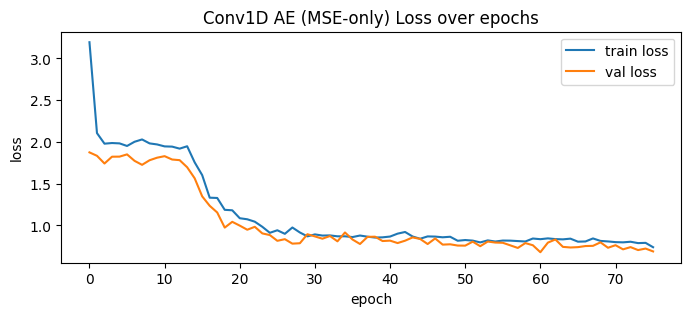

In [14]:
plt.figure(figsize=(8,3))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.title("Conv1D AE (MSE-only) Loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


mu mean/std: -0.1554320752620697 1.5371830463409424
logvar mean: -4.072381019592285
0 orig max 3.0 recon max 2.4527173
1 orig max 0.74652195 recon max 0.36325175
2 orig max 1.1307268 recon max 0.74741423


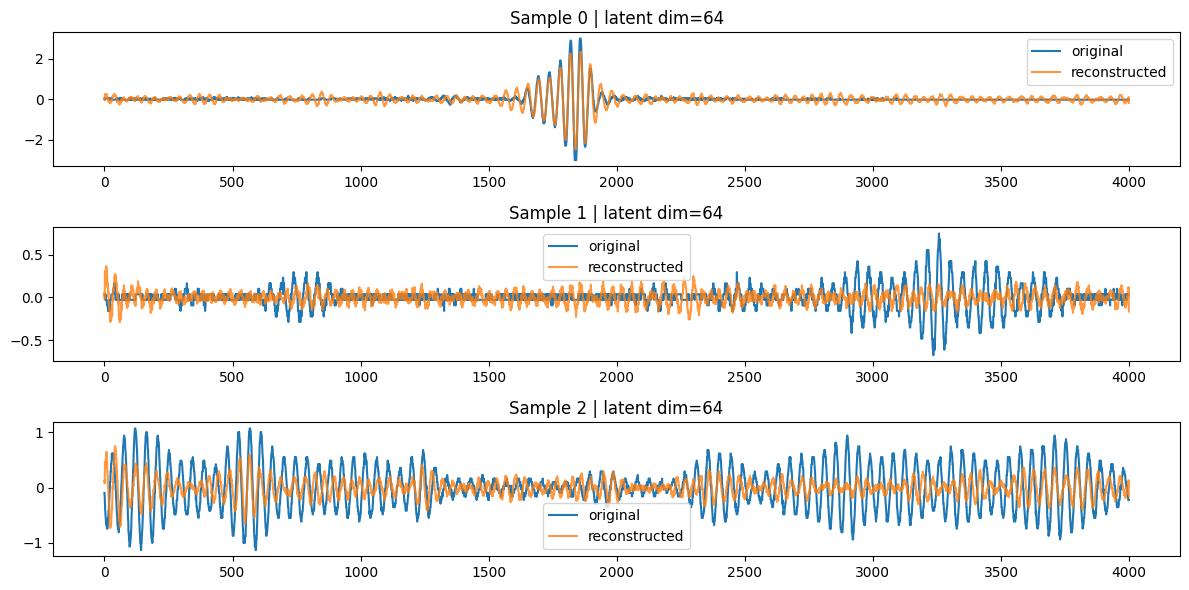

Example latent z[0]: [-1.5481701  -0.6915682  -3.1695614  -1.0664738  -3.1191998  -1.4672365
 -2.8334196   1.6295888   1.3880787   0.66008896 -0.6418927  -1.4386693
 -0.9962822  -0.6734954  -0.8466217   0.2380213   0.40258324 -1.4963007
 -1.9072356  -0.07565187 -2.7968452   3.1516762   2.5520468  -0.12836419
  1.402328   -0.9353551  -2.2469225  -0.23855442 -0.23678309  0.34294903
 -1.0370177  -0.93193626  3.4572804  -0.74639237  2.719877    0.6414201
  2.453584   -0.8670782   0.37348348  0.77800703 -3.0155175   1.0020051
  0.25517282  1.6267684  -0.65893066  1.22052     1.2236698   0.08186954
  2.9234452   0.653278    3.5718882  -0.21116112  1.4643493  -0.655266
  0.8876575  -0.08637509  0.57865536  1.4304866  -0.7244898  -0.14739373
 -2.8336983  -0.99219304  0.96475285 -0.86855173]


In [15]:
# 从 val 里拿一批
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

x = next(iter(val_loader))[:10].to(device)  # (10,1,T)

with torch.no_grad():
    x_hat, mu, logvar, z = model(x)
print("mu mean/std:", mu.mean().item(), mu.std().item())
print("logvar mean:", logvar.mean().item())

x_np = x[:,0,:].cpu().numpy()
xhat_np = x_hat[:,0,:].cpu().numpy()

n_show = min(10, len(x_np))
plt.figure(figsize=(14, 2.5 * n_show))
for i in range(n_show):
    print(i, "orig max", np.max(np.abs(x_np[i])), "recon max", np.max(np.abs(xhat_np[i])))
    plt.subplot(n_show, 1, i+1)
    plt.plot(x_np[i], label="original")
    plt.plot(xhat_np[i], label="reconstructed", alpha=0.8)
    plt.title(f"Sample {i} | latent dim={latent_dim}")
    plt.legend()
plt.tight_layout()
plt.show()

print("Example latent z[0]:", z[0].cpu().numpy())


In [16]:
import numpy as np
from IPython.display import Audio, display

sr = SR_EXPECT  # 8000

def prep(w):
    w = w.astype(np.float32)
    # 如果在 [0,1]，映射回 [-1,1]
    if w.min() >= 0 and w.max() <= 1.0:
        w = w * 2.0 - 1.0
    m = np.max(np.abs(w)) + 1e-8
    w = w / m
    return np.clip(w, -1.0, 1.0)

silence = np.zeros(int(0.2 * sr), dtype=np.float32)
n_listen = min(10, len(x_np))

for i in range(n_listen):
    orig  = prep(x_np[i])
    recon = prep(xhat_np[i])
    print(f'--- Sample {i} | orig max {np.max(np.abs(x_np[i])):.4f} | recon max {np.max(np.abs(xhat_np[i])):.4f} ---')
    # A/B: 原声 -> 静音 -> 重建
    ab = np.concatenate([orig, silence, recon])
    display(Audio(ab, rate=sr))


Original:


Reconstruction:


A/B combined:


In [17]:
# import soundfile as sf

# sf.write(f"{SAVE_DIR}/orig_{RUN_NAME}.wav", orig, sr)
# sf.write(f"{SAVE_DIR}/recon_{RUN_NAME}.wav", recon, sr)
# sf.write(f"{SAVE_DIR}/AB_{RUN_NAME}.wav", ab, sr)

In [18]:
print("Quantitative Assessment of Reconstruction Quality (Standard Deviation):")
n_eval = min(10, len(x_np))
for i in range(n_eval):
    orig_std = np.std(x_np[i])
    recon_std = np.std(xhat_np[i])
    ratio = recon_std / (orig_std + 1e-8)
    print(f"Sample {i}: Original STD = {orig_std:.4f}, Reconstructed STD = {recon_std:.4f}, Ratio = {ratio:.2%}")


Quantitative Assessment of Reconstruction Quality (Standard Deviation):
Sample 0: Original STD = 0.3624, Reconstructed STD = 0.3332
Sample 1: Original STD = 0.1264, Reconstructed STD = 0.0728
Sample 2: Original STD = 0.3878, Reconstructed STD = 0.1661
